In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [8]:
cd '/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting'

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting


In [9]:
# %load src/reg_model_class.py
import numpy as np
import pandas as pd

import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from scipy.interpolate import make_interp_spline
# from data_clean_script import clean_data, replace_initial_values, replace_with_moving_averages, load_and_clean_data, create_spline, convert_to_date, fill_na_with_surround

from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib

from matplotlib.dates import (DAILY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)


class reg_model(object):
    def __init__(self, X, y, log_trans_y=False, day_cutoff=93):
        '''
        Day cutoff is split between training and testing data.
        '''
        self.X = X
        if log_trans_y == True:
            elim_invalid = y.copy()
            elim_invalid[elim_invalid < 0] = 0
            self.y = np.log(elim_invalid + 1)
        else:
            self.y = y
        train_mask = self.X['days_elapsed(t)'] < day_cutoff
        holdout_mask = self.X['days_elapsed(t)'] >= day_cutoff
        self.log_trans_y = log_trans_y
        self.X_train, self.X_test, self.y_train, self.y_test = self.X[
            train_mask], self.X[holdout_mask], self.y[train_mask], self.y[holdout_mask]
        self.error_metric = None

    def lin_reg(self):
        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def log_reg(self):
        self.model = LogisticRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def ridge_reg(self, alpha=0.5):
        def optimize_alpha(alpha_list):
            pass
        self.model = Ridge(alpha=alpha)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rss'

    def rand_forest(self, n_trees=100):
        '''
        Upon inspection of the model over time, the number of new cases shows a period of exponential growth, then linear growth where the new cases levels off. Then a random forest model can be applied. 
        '''
        if n_trees == 'optimize':
            '''
            If set to optimize, will take a selection of 1 to max_trees and uses number that minimizes error in training set.
            This can be plotted by uncommenting out the plt.plot(n, error) line.
            '''
            max_trees = 100
            n = np.arange(1, max_trees + 1, 1)
            error = []
            for each in n:
                self.model = RandomForestRegressor(
                    n_estimators=each, n_jobs=-1, random_state=1)
                self.model.fit(self.X_train, self.y_train)
                self.error_metric = 'rmse'
                error.append(self.evaluate_model())
            #plt.plot(n, error)
            n_trees = n[error.index(min(error))]
        # n_jobs = -1, random_state = 0, max_depth = 3, oob_score = False, random_state = 10
        self.model = RandomForestRegressor(
            n_estimators=n_trees, random_state=None)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def evaluate_model(self, print_err_metric=False):
        self.y_hat = self.model.predict(self.X_test)
        self.predicted_vals_df = pd.DataFrame(self.y_test)
        self.predicted_vals_df['days_elapsed(t)'] = self.X_test['days_elapsed(t)']
        self.predicted_vals_df['y_hat'] = self.y_hat
        self.predicted_vals_df.sort_index(inplace=True)
        if self.error_metric == 'rmse':
            rmse = np.sqrt(mean_squared_error(self.y_test, self.y_hat))
            if print_err_metric:
                print('rmse:', rmse)
            return rmse
        elif self.error_metric == 'rss':
            rss = np.mean((self.y_test - self.y_hat)**2)
            if print_err_metric:
                print('rss: ', rss)
            return rss

    def forecast_vals(self, to_forecast_df):
        self.forecasted = self.model.predict(to_forecast_df)
        return self.forecasted

    def plot_model(self, use_smoothed=True, threshold=100, save_name=None, xvar='days_elapsed(t)', convDate=True):
        '''
        Use smoothed generates data using moving average. 
        Convdate converts days elapsed into date
        '''
        register_matplotlib_converters()
        fig, ax = plt.subplots(figsize=(10, 6))
        if self.log_trans_y == True:
            self.y_test = np.e ** self.y_test
        ax.bar(self.X_test.loc[:, xvar].apply(convert_to_date),
               self.y_test, color='blue', label="Test Data")
        ax.bar(self.X_train.loc[:, xvar].apply(convert_to_date),
               self.y_train, color='red', label="Training Data")
        if use_smoothed == True:
            x, y = create_spline(self.X[xvar], self.y, day_delay = 0)
            x = pd.DataFrame(x).iloc[:, 0].apply(convert_to_date)
            ax.plot_date(x, y, c='green', label='Moving Average - 7 days',
                         xdate=True, marker='', ls='-')
            fig.autofmt_xdate()

            rule = rrulewrapper(DAILY, interval=7)
            loc = RRuleLocator(rule)
            formatter = DateFormatter('%y/%m/%d')
            ax.xaxis.set_major_locator(loc)
            ax.xaxis.set_major_formatter(formatter)
            ax.xaxis.set_tick_params(rotation=30, labelsize=14)
            ax.set_xlabel('Date')
        else:
            x = self.X_test
            y = self.y
            ax.plot(self.X_test.loc[:, xvar],
                    self.y_test, c='green', label='Predicted Data')
            ax.set_xlabel('Days Since Feb 15')
        try:
            x_thresh = convert_to_date(x[np.where(np.e**y >= threshold)[0][0]])
            ax.axvline(x_thresh, label='Threshold', color='black', ls='--')
        except:
            pass
        ax.legend()
        ax.set_ylabel('Daily Cases per 1 Million Population')
        ax.set_title('New York COVID-19 New Cases')
        fig.tight_layout()
        if save_name != None:
            fig.savefig('images/{}'.format(save_name))


In [10]:
# %load src/data_clean_script.py
import pandas as pd
import numpy as np
import datetime

def create_spline(x, y, day_delay, t=7):
    '''
    Use moving average of t points at day_delay
    '''
    y_raw = y.values if day_delay == 0 else y.values[:-day_delay]
    weights = np.repeat(1.0, t) / t
    mov_avgs_y = np.convolve(y_raw, weights, 'valid')
    mov_avgs_x = list(
        range(int(x.values[0] + t + day_delay), int(x.values[-1] + 2)))
    return mov_avgs_x, mov_avgs_y[:len(mov_avgs_x) + 1]


def clean_data(df, datetime_col=None):
    clean_df = df.copy()
    if datetime_col != None:
        clean_df[datetime_col] = pd.to_datetime(clean_df[datetime_col])
    return clean_df


def convert_to_date(days_elapsed, original_date=datetime.date(2020, 2, 15)):
    date_result = original_date + datetime.timedelta(days_elapsed)
    return date_result


def replace_initial_values(df, col_change, val_col):
    '''
    When creating new feature columns using difference of existing columns, this function will replace the initial value in val_col of col_change with a 0.
    '''
    prev = None
    for i, st in zip(df.index, df[col_change]):
        if st != prev:
            df.loc[i, val_col] = 0
        else:
            continue
        prev = st
    return df


def replace_with_moving_averages(df, cols, day_delay, xcol='days_elapsed'):
    '''
    Replaces applicable rows  in columns with weekly average days_past days ago.
    Day delay is an optional parameter if we want to set the moving average to the weekly moving average x number of days ago.

    '''
    df_ma = df.copy()
    for col in cols:
        max_index = max(df_ma.index)
        mv_avgs = create_spline(
            df_ma[xcol], df_ma[col], day_delay=day_delay)[1]
        applicable_row_indices = max_index - len(mv_avgs) + 1
        df_ma.loc[applicable_row_indices:, col] = mv_avgs
    return df_ma


def load_and_clean_data(new_cases_per_pop = True):
    '''
    Arguments: new_cases_per_pop = True
    Sets up and generates dataframe for analysis 
    If new cases per pop is disabled, will use raw number of new cases instead.
    '''

    #Import and clean covid data (Cases in 2020)
    covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
    covid_df = clean_data(covid_raw_df, datetime_col='date')
    covid_df.sort_values(['state', 'date'], inplace=True)
    covid_df['New_Cases'] = covid_df['cases'].diff()

    covid_df = replace_initial_values(covid_df, 'state', 'New_Cases')

    '''
    Mobility Data - From Google
    #The baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020
    https://www.google.com/covid19/mobility/index.html?hl=en
    '''

    mobility_raw_df = pd.read_csv(
        'data/Global_Mobility_Report.csv', low_memory=False)
    US_mobility_raw_df = mobility_raw_df[(mobility_raw_df['country_region'] == 'United States') & (
        mobility_raw_df['sub_region_1'].isnull() == False) & (mobility_raw_df['sub_region_2'].isnull() == True)]
    mobility_df = clean_data(US_mobility_raw_df, datetime_col='date')
    mobility_df.reset_index(inplace=True)
    mobility_df.drop(['index', 'country_region_code',
                      'country_region', 'sub_region_2'], axis=1, inplace=True)
    mobility_df.rename(columns=lambda x: x.replace(
        '_percent_change_from_baseline', ''), inplace=True)
    mobility_df.rename(columns={'sub_region_1': 'state'}, inplace=True)
    num_cols = ['retail_and_recreation', 'grocery_and_pharmacy',
                'parks', 'transit_stations', 'workplaces', 'residential']
    mobility_df[num_cols] = mobility_df[num_cols].apply(pd.to_numeric)

    #Convert to percent of normal
    mobility_df[num_cols] = mobility_df[num_cols].apply(
        lambda x: (x + 100)/100)
    states = list(set(mobility_df['state']))
    '''
    Transp data - From Apple
    The CSV file and charts on this site show a relative volume of directions requests per country/region, sub-region or city compared to a baseline volume on January 13th, 2020. We define our day as midnight-to-midnight, Pacific time.
    https://www.apple.com/covid19/mobility 
    '''
    transp_raw_df = pd.read_csv('data/applemobilitytrends-2020-06-01.csv')
    transp_df = transp_raw_df[(transp_raw_df['geo_type'] == 'sub-region')
                              & (transp_raw_df['region'].isin(states))].copy()
    #Driving is only available transportation type data available for statewide data
    transp_df.drop(['geo_type', 'alternative_name', 'transportation_type', 'sub-region', 'country'],
                   axis=1, inplace=True)
    transp_df.set_index('region', inplace=True)
    transp_df = (transp_df.T) / 100  # Convert to percentage of normal
    transp_df.reset_index(inplace=True)
    transp_df.rename(columns={'index': 'date'}, inplace=True)
    transp_df['date'] = pd.to_datetime(transp_df['date'])
    transp_df = transp_df.melt(id_vars=["date"])
    transp_df.rename(columns={'region': 'state'}, inplace=True)

    mobility_df = mobility_df.merge(
        transp_df, how='inner', on=['date', 'state'])
    covid_df = mobility_df.merge(covid_df, how='inner', on=['date', 'state'])
    covid_df.rename(columns={'value': 'driving'}, inplace=True)
    covid_df.drop(['cases', 'deaths', 'fips'], axis=1, inplace=True)

    #Converts date into days elapsed since outbreak- some functions don't work with datetime objects
    #February 15th is earliest data
    min_date = datetime.datetime(2020, 2, 15)
    covid_df['date'] = covid_df['date'].apply(
        lambda x: (x.to_pydatetime() - min_date).days)
    dates = covid_df['date']
    covid_df.rename(columns={'date': 'days_elapsed'}, inplace=True)

    #Importing state populations and land areas - going to convert cases to new cases per capita for better comparison, implement state density
    state_pops = pd.read_csv('data/pop_by_state.csv',
                             header=1, usecols=['State', 'Pop'])
    state_area = pd.read_csv('data/state_area.csv',
                             usecols=['State', 'TotalArea'])
    state_pops.rename(columns={'State': 'state'}, inplace=True)
    state_area.rename(columns={'State': 'state'}, inplace=True)
    state_pops = state_pops.merge(state_area, on='state')
    state_pops['pop_density'] = state_pops['Pop'] / state_pops['TotalArea']
    
    if new_cases_per_pop == True:
        state_pops['Pop'] = state_pops['Pop'] / 1000000
        covid_df = covid_df.merge(state_pops, on='state')
        covid_df['New_Cases_per_pop'] = covid_df['New_Cases'] / covid_df['Pop']
        covid_df.drop(['TotalArea', 'Pop'], axis=1, inplace=True)
        covid_df.drop(['New_Cases'], axis=1, inplace=True)
        
    #2 missing park values; manually fill them in with average of surrounding value
    covid_df.loc[507, 'parks'] = (
        covid_df.loc[506, 'parks'] + covid_df.loc[508, 'parks'])/2
    covid_df.loc[514, 'parks'] = (
        covid_df.loc[513, 'parks'] + covid_df.loc[515, 'parks'])/2

    return covid_df


def fill_na_with_surround(df, col, ind_loc = 'iloc'):
    '''
    Can be used to fill NA values with the average of the two surrounding values in a series of missing values.
    Note: Currently only tested if one continuous series of non numeric values exists in the specified col.
    Also assumes valid value exists after the series of NaNs.
    '''
    indices = df[df[col].isnull()].index.values
    if ind_loc == 'iloc':
        val_1 = df[col].iloc[min(indices) - 1]
        val_2 = df[col].iloc[max(indices) + 1]
    else:
        val_1 = df[col].loc[min(indices) - 1]
        val_2 = df[col].loc[max(indices) + 1]        
    replace = (val_1 + val_2) / 2
    df[col].fillna(replace, inplace=True)
    return df


In [15]:
# %load src/main.py
'''
See notebooks/EDA.ipynb for plots
'''
import pandas as pd
import numpy as np
import datetime

from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('fivethirtyeight')
plt.close('all')

#Define minimum threshold of cases per 1 million people in each state to begin training data on.
#Threshold is the minimum value at which data is output; Used to reduce misleading predictions
#(low new cases count and low social distancing parameters before pandemic)
threshold = 450

'''
Import scripts from other .py files
'''
# from reg_model_class import reg_model
# from data_clean_script import clean_data, replace_initial_values, replace_with_moving_averages, load_and_clean_data, create_spline, convert_to_date, fill_na_with_surround

def state_plot(state, df):
    fig, axes = plt.subplots(8, 1, figsize=(12, 15))
    for i, ax in enumerate(axes, 2):
        query = df[df['state'] == state]['days_elapsed']
        x = query.values
        y = covid_df.loc[query.index].iloc[:, i]
        ax.plot(x, y)
    fig.show()


def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def fill_diagonals(df, preds, model, start_row=31, n_interval=21):
    df.fillna(0, inplace=True)
    n_rows = df.shape[0]
    new_preds = list(preds.values)
    for row in range(start_row, n_rows)[:]:
        new_pred = model.predict(df[row:row + 1])[0]
        new_preds.append(new_pred)
        j = 0
        for col in range(n_interval-1, 0, -1):
            try:
                if df.iloc[row + j, col] == 0:
                    df.iloc[row + j, col] = new_pred
                j += 1
            except:
                continue
    new_pred = model.predict(df[-1:-2:-1])[0]
    new_preds.append(new_pred)
    return df, new_preds


def generate_prediction_df(level, total_x, total_y, predictions=21):

    #Part 1: Expands time lagged Daily New Cases columns

    columns = ['days_elapsed(t)', 'retail_and_recreation(t)', 'grocery_and_pharmacy(t)',
               'parks(t)', 'transit_stations(t)', 'workplaces(t)', 'residential(t)', 'driving(t)']

    levelDict = {'High': [0.34, 0.5, 0.36, 0.295, 0.4, 1.3, 0.385],
                 'Medium': [0.6, 0.8, 0.7, 0.7, 0.75, 1.1, 0.7],
                 'Low': [1, 1, 1, 1, 1, 0.9, 1]
                 }

    if type(level) != str:
        pred_params = level
    else:
        pred_params = levelDict[level]
    pred_df = total_x.copy()
    last_recorded_day = int(pred_df['days_elapsed(t)'].max())
    for i in range(last_recorded_day + 1, last_recorded_day + predictions + 1):
        pred_df_row = pd.DataFrame([i] + pred_params).T
        pred_df_row.columns = columns
        pred_df = pred_df.append(pred_df_row, sort=False)

    y_pred = total_y

    # Part 2: Fills in blank known new cases values
    n_rows = pred_df.shape[0]
    pred_df.fillna(0, inplace=True)
    row_start = pred_df.shape[0] - \
        pred_df[pred_df['Daily New Cases(t-1)'] == 0].count()[0]
    col_start = 20
    new_preds = list(y_pred.values)
    pred_df.iloc[row_start, col_start] = y_pred.values[-1]
    for row in range(row_start, n_rows):
        for col in range(col_start - 1, -1, -1):
            pred_df.iloc[row, col] = pred_df.iloc[row - 1, col + 1]
    #Part 3: Fills in rest of time lagged values for future t values, predicting based on prior predictions
    fill_diag_and_predictions = fill_diagonals(
        pred_df, y_pred.loc[:45], rf_model.model, start_row=row_start, n_interval=21)
    pred_df = fill_diag_and_predictions[0]
    pred_y = fill_diag_and_predictions[1][-pred_df.shape[0]:]
#     pred_y = fill_diagonals(pred_df,y_pred, rf_model.model, n_interval = 21)[1][-pred_df.shape[0]:]
    return pred_df, pred_y

def state_analysis(covid_df, state = 'New York'):
    '''
    Produces random forest model for specified state, returns tuple of model and time series dataframe
    '''
    mask1 = (covid_df['state'] == state)
    state_df = covid_df[mask1]
    y = state_df.pop('New_Cases_per_pop')
    X = state_df.iloc[:, 1: -1]

    #Calculate moving average, use as target variable instead of raw new cases/pop
    smooth_x, smooth_y = create_spline(X['days_elapsed'], y, day_delay = 0)
    mov_avg_df = pd.DataFrame([smooth_x, smooth_y]).T
    mov_avg_df.columns = ('days_elapsed', 'Daily New Cases')
    state_df = replace_with_moving_averages(
        state_df, state_df.columns[2:-1], day_delay=10)

    #Mask to limit start of moving average dataframe to when the number of daily new cases reaches threshold
    mask_mov_avg = (mov_avg_df['Daily New Cases'] >= threshold) | (
        mov_avg_df['days_elapsed'] > 55)
    mov_avg_df = mov_avg_df[mask_mov_avg]
    revised_df = state_df.merge(mov_avg_df, on='days_elapsed').iloc[:, 1:]
    fill_na_with_surround(revised_df, 'driving')

    #Only one state is currently considered in this study, no need to compare pop_density
    revised_df.drop('pop_density', axis=1, inplace=True)

    #Create time series dataframe, fit it into model and evaluate
    values = revised_df.values
    ts_frame_data = series_to_supervised(values, revised_df.columns, 21, 1)
    ts_frame_data = ts_frame_data.iloc[:,
                                       8:-5:9].join(ts_frame_data.iloc[:, -9:])
    ts_frame_data.index.name = state
    ts_y = ts_frame_data.pop('Daily New Cases(t)')
    ts_x = ts_frame_data
    rf_model = reg_model(ts_x, ts_y)
    rf_model.rand_forest(n_trees=100)
    rf_model.evaluate_model(print_err_metric=True)
    return rf_model, ts_x, ts_y

if __name__ == '__main__':
    covid_df = load_and_clean_data()
    NY_rf, NY_ts_df, NY_ts_y = state_analysis(covid_df, state = 'New York')

    #Plots in notebooks/EDA.ipynb


rmse: 24.31125148258445


In [16]:
NY_ts_df

,Daily New Cases(t-21),Daily New Cases(t-20),Daily New Cases(t-19),Daily New Cases(t-18),Daily New Cases(t-17),Daily New Cases(t-16),Daily New Cases(t-15),Daily New Cases(t-14),Daily New Cases(t-13),Daily New Cases(t-12),...,Daily New Cases(t-2),Daily New Cases(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t)
New York,,,,,,,,,,,,,,,,,,,,,
21,458.888106,472.519464,474.701951,481.264109,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,...,309.891113,315.431837,71.0,0.354286,0.772857,0.701429,0.302857,0.411429,1.248571,0.467614
22,472.519464,474.701951,481.264109,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,...,315.431837,340.666384,72.0,0.358571,0.760000,0.715714,0.308571,0.420000,1.244286,0.477243
23,474.701951,481.264109,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,...,340.666384,339.299574,73.0,0.354286,0.730000,0.675714,0.305714,0.424286,1.244286,0.479214
24,481.264109,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,...,339.299574,333.494306,74.0,0.372857,0.755714,0.705714,0.311429,0.435714,1.242857,0.498286
25,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,...,333.494306,325.859275,75.0,0.388571,0.778571,0.762857,0.322857,0.442857,1.237143,0.515329
26,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,...,325.859275,318.944392,76.0,0.384286,0.767143,0.722857,0.318571,0.444286,1.238571,0.513929
27,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,...,318.944392,306.900297,77.0,0.382857,0.768571,0.718571,0.320000,0.447143,1.237143,0.518557
28,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,...,306.900297,274.515717,78.0,0.384286,0.768571,0.722857,0.321429,0.450000,1.235714,0.522500
29,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,...,274.515717,229.513863,79.0,0.382857,0.764286,0.712857,0.318571,0.451429,1.235714,0.525543


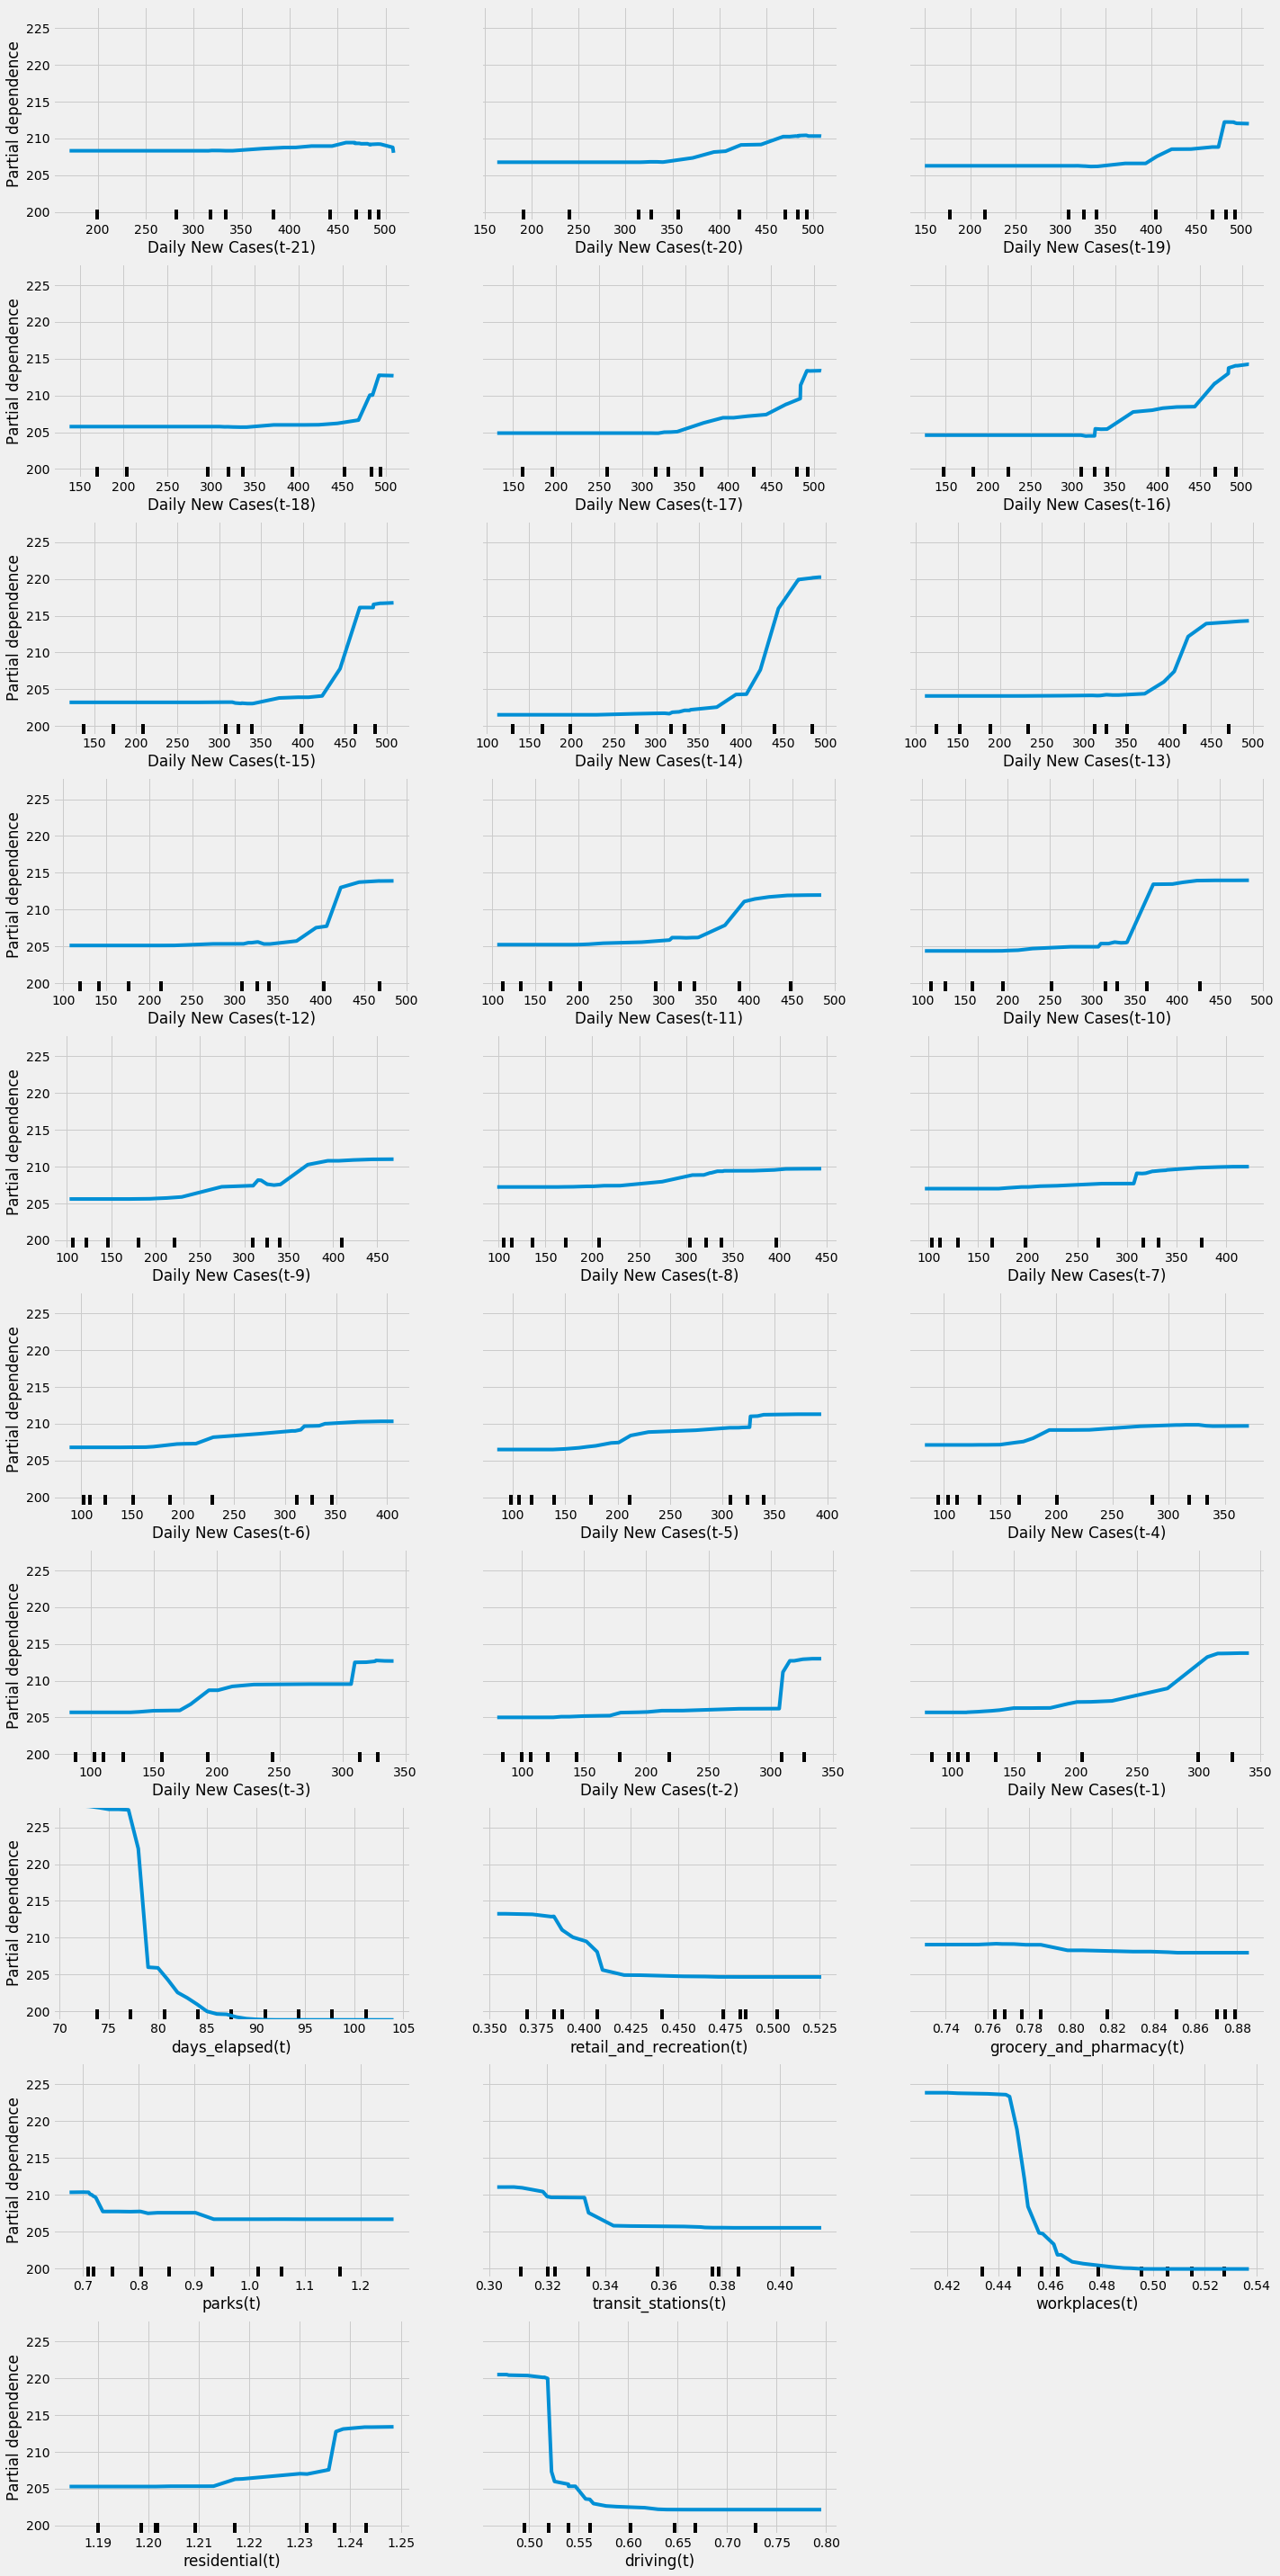

In [17]:
from sklearn.inspection import plot_partial_dependence
plot_partial_dependence(NY_rf.model, NY_ts_df, NY_ts_df.columns, grid_resolution = 50)
fig = plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(40)
fig.tight_layout()

In [67]:
## from pandas.plotting import register_matplotlib_converters
pop_density = covid_df[['state', 'pop_density']].drop_duplicates()
NY_pop_density = pop_density[(pop_density['state'] == 'New York')]['pop_density'].values[0] 

def get_day_of_peak(df, target = 'New_Cases'):
    top = df.sort_values(target, ascending = False).iloc[0]
    peak_day = top.loc['days_elapsed']
    peak_val = top.loc['New_Cases']
    return peak_day, peak_val

class other_state(object):
    '''
    use_new_case_per_capita is False by default for scaling to make units more interpretable when normalizing models
    mvg_avg_df = replace_with_moving_averages(self.NY_df, self.NY_df.columns[2:-1], day_delay = 3)
        mvg_avg_df = replace_with_moving_averages(self.df, self)
        '''
    def __init__(self, state, per_capita = False, use_mvg_avg = True):
        
        self.state = state
        self.pop_density = pop_density[(pop_density['state'] == state)]['pop_density'].values[0] 
        if per_capita == True:
            covid_df = load_and_clean_data(new_cases_per_pop = True)
            self.df = covid_df[covid_df['state'] == state]
            self.NY_df = covid_df[covid_df['state'] == 'New York']
            if use_mvg_avg == True:
                self.df = self.apply_moving_avgs(self.df, ['New_Cases_per_pop'])
                self.df = self.apply_moving_avgs(self.df, self.df.columns[2: -1], day_delay = 3)
                self.NY_df = self.apply_moving_avgs(self.NY_df, ['New_Cases'])
                self.NY_df = self.apply_moving_avgs(self.NY_df, self.NY_df.columns[2: -1], day_delay = 3)
            self.y = self.df['New_Cases_per_pop']
            self.NY_data_y = self.NY_df['New_Cases_per_pop']
        else:
            covid_df = load_and_clean_data(new_cases_per_pop = False)
            self.df = covid_df[covid_df['state'] == state]
            self.NY_df = covid_df[covid_df['state'] == 'New York']
            if use_mvg_avg == True:
                self.df = self.apply_moving_avgs(self.df, ['New_Cases'])
                self.df = self.apply_moving_avgs(self.df, self.df.columns[2: -1], day_delay = 3)
                self.NY_df = self.apply_moving_avgs(self.NY_df, ['New_Cases'])
                self.NY_df = self.apply_moving_avgs(self.NY_df, self.NY_df.columns[2: -1], day_delay = 3)
            self.y = self.df['New_Cases']
            self.NY_data_y = self.NY_df['New_Cases']
        
        self.X = self.df['days_elapsed']
        self.NY_data_X = self.NY_df['days_elapsed']
        
    def pop_dens_scale(self):
        self.pop_scale = pop_density[(pop_density['state'] == 'New York')]['pop_density'].values[0] / pop_density[(pop_density['state'] == self.state) ]['pop_density'].values[0]
        return self.pop_scale
    
    def apply_moving_avgs(self, df, cols, day_delay = 0):
        '''
        replace_with_moving_averages(
        Minnesota_Analysis.NY_df, Minnesota_Analysis.NY_df.columns[2:-1], day_delay=3)
        '''
        mvg_avg_df = replace_with_moving_averages(df, cols, xcol='days_elapsed', day_delay=0)
        return mvg_avg_df
    
    def normalize_to_NY(self, x_mod_adj):
        '''        
        Currently determined by visual inspection of plots:
        x_mod is the number of days the virus infection appears to be behind NY
        y_mod is a number subtracted from the density scale to normalize peaks/shape of data to match NY.
        '''
        self.x_mod = get_day_of_peak(self.df)[0] + x_mod_adj
        self.y_scale = get_day_of_peak(self.NY_df)[1]/ get_day_of_peak(self.df)[1]
        self.day_diff = get_day_of_peak(self.df)[0] - get_day_of_peak(self.NY_df)[0] + x_mod_adj
    
    def plot_vs_NY(self, x_mod_adj = 0, axis = 'Date', save = False):
        NY_peak_day = 55
        register_matplotlib_converters()  
        
        fig, ax = plt.subplots(figsize = (12,6))
        if axis == 'Date':
            NY_X = self.NY_data_X.apply(convert_to_date)
            state_X = self.X.apply(convert_to_date)
        elif axis == 'Days Since Peak of Outbreak':
            self.normalize_to_NY(x_mod_adj = x_mod_adj)
            NY_X = self.NY_data_X - NY_peak_day
            state_X = self.X - self.x_mod
            ax.annotate("*X - Shifted Back {0:.{1}f} days\n*y - Scaled {2:.{3}f} times".format(self.day_diff, 0, self.y_scale,1), 
                        xy = (0.1, 0.72), xycoords = 'figure fraction')
        else:
            NY_X = self.NY_data_X
            state_X = self.X
        
        
        ax.plot(NY_X, self.NY_data_y, label = 'New York', c = 'red')
#         ax.legend(loc = 2)
        ax.set_title('Covid-19 New Cases Comparison (Weekly Average)')
        ax.set_xlabel(axis)
        ax.set_ylabel('NY Daily New Cases')
        
        ax2 = ax.twinx()
        ax2.plot(state_X, self.y, label = self.state + '*')
#         ax2.legend(loc = 1)
        ax2.set_ylabel('{} Daily Cases'.format(self.state))
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax.legend(h1 + h2, l1 + l2, loc = 2)
        ax2.grid(None)
        fig.tight_layout()
        
        if save != False:
            fig.savefig(save)
            
    def scale_state_to_NY(self):
        '''
        In order to get insight as to how the specified state should aim for social distancing, the data
        will be scaled up to numbers for predictions with NY's random forest, then scaled back down for
        interpretable estimates.
        '''
        fill_na_with_surround(self.df, 'driving', ind_loc ='loc')
        self.df['New_Cases'] = (self.df['New_Cases'] * self.y_scale) / (self.pop_density)
        self.df['days_elapsed'] = self.df['days_elapsed'] - self.x_mod
        self.df.drop('state', axis = 1, inplace = True)
        self.df.rename(columns = {'New_Cases': 'Daily New Cases'}, inplace = True)
        self.ts_df = series_to_supervised(self.df.values, self.df.columns, 21, 1)
        self.ts_df = self.ts_df.iloc[:,8:-5:9].join(self.ts_df.iloc[:, -9:])
        self.ts_df.index.name = self.state
        
    def scale_back_to_state(self):
        pass

In [68]:
14/65

#Possible replace default high/medium/low social distancing parameters with realistic low values from random forest training Data

0.2153846153846154

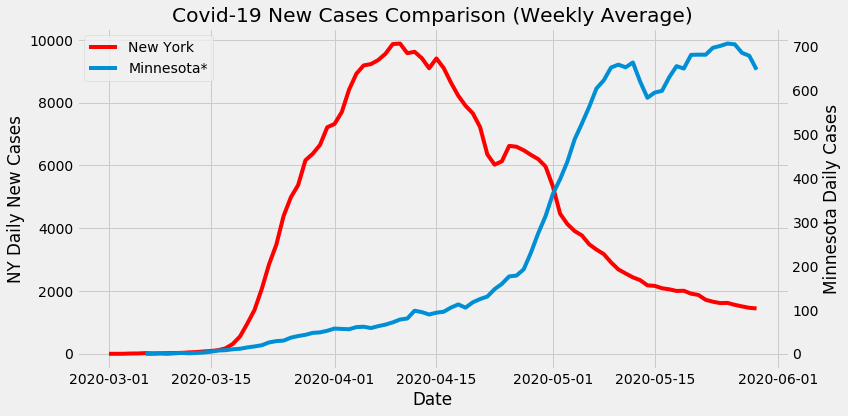

In [77]:
Minnesota_Analysis = other_state('Minnesota', False)
Minnesota_Analysis.plot_vs_NY(x_mod_adj = 0, axis = 'Date', save = 'images/MNvsNY0')

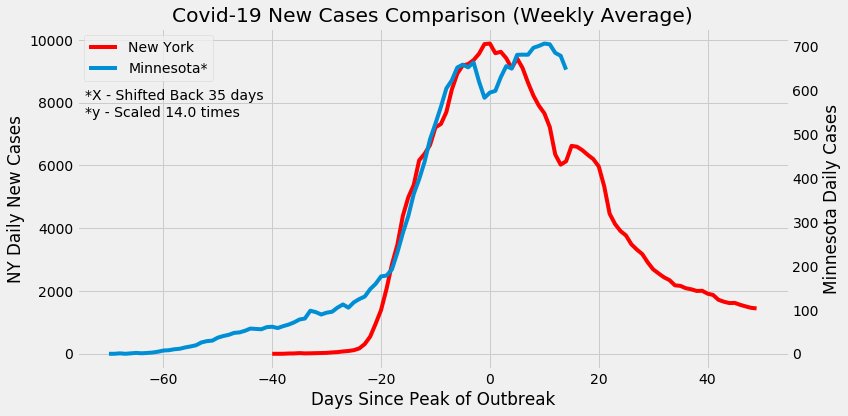

In [81]:
Minnesota_Analysis.plot_vs_NY(x_mod_adj = -10, axis = 'Days Since Peak of Outbreak', save = 'images/MNvsNY1')

In [22]:
# Minnesota_Analysis.scale_state_to_NY()
Minnesota_Analysis.df

,state,days_elapsed,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving,New_Cases
1913,Minnesota,20,1.060000,1.060000,1.060000,1.030000,0.990000,1.000000,1.306800,0.000000
1914,Minnesota,21,1.070000,1.090000,1.210000,1.070000,1.030000,0.990000,1.294500,0.000000
1915,Minnesota,22,1.130000,1.120000,1.930000,1.070000,1.020000,0.980000,0.942600,1.000000
1916,Minnesota,23,1.040000,1.030000,0.990000,0.950000,0.980000,1.010000,0.946700,0.000000
1917,Minnesota,24,1.060000,1.040000,1.060000,0.990000,0.980000,1.010000,0.990900,1.000000
...,...,...,...,...,...,...,...,...,...,...
1993,Minnesota,100,0.748571,1.025714,2.487143,0.534286,0.570000,1.132857,1.095771,706.142857
1994,Minnesota,101,0.744286,1.022857,2.368571,0.534286,0.570000,1.134286,1.095100,704.428571
1995,Minnesota,102,0.744286,1.021429,2.331429,0.534286,0.572857,1.134286,1.105186,685.000000
1996,Minnesota,103,0.742857,1.015714,2.352857,0.542857,0.577143,1.132857,1.128700,678.285714


In [33]:
Minnesota_Analysis.df

,state,days_elapsed,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving,New_Cases
1913,Minnesota,20,1.060000,1.060000,1.060000,1.030000,0.990000,1.000000,1.306800,0.000000
1914,Minnesota,21,1.070000,1.090000,1.210000,1.070000,1.030000,0.990000,1.294500,0.000000
1915,Minnesota,22,1.130000,1.120000,1.930000,1.070000,1.020000,0.980000,0.942600,1.000000
1916,Minnesota,23,1.040000,1.030000,0.990000,0.950000,0.980000,1.010000,0.946700,0.000000
1917,Minnesota,24,1.060000,1.040000,1.060000,0.990000,0.980000,1.010000,0.990900,1.000000
...,...,...,...,...,...,...,...,...,...,...
1993,Minnesota,100,0.748571,1.025714,2.487143,0.534286,0.570000,1.132857,1.095771,706.142857
1994,Minnesota,101,0.744286,1.022857,2.368571,0.534286,0.570000,1.134286,1.095100,704.428571
1995,Minnesota,102,0.744286,1.021429,2.331429,0.534286,0.572857,1.134286,1.105186,685.000000
1996,Minnesota,103,0.742857,1.015714,2.352857,0.542857,0.577143,1.132857,1.128700,678.285714


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a259ed710>,
      dtype=object)

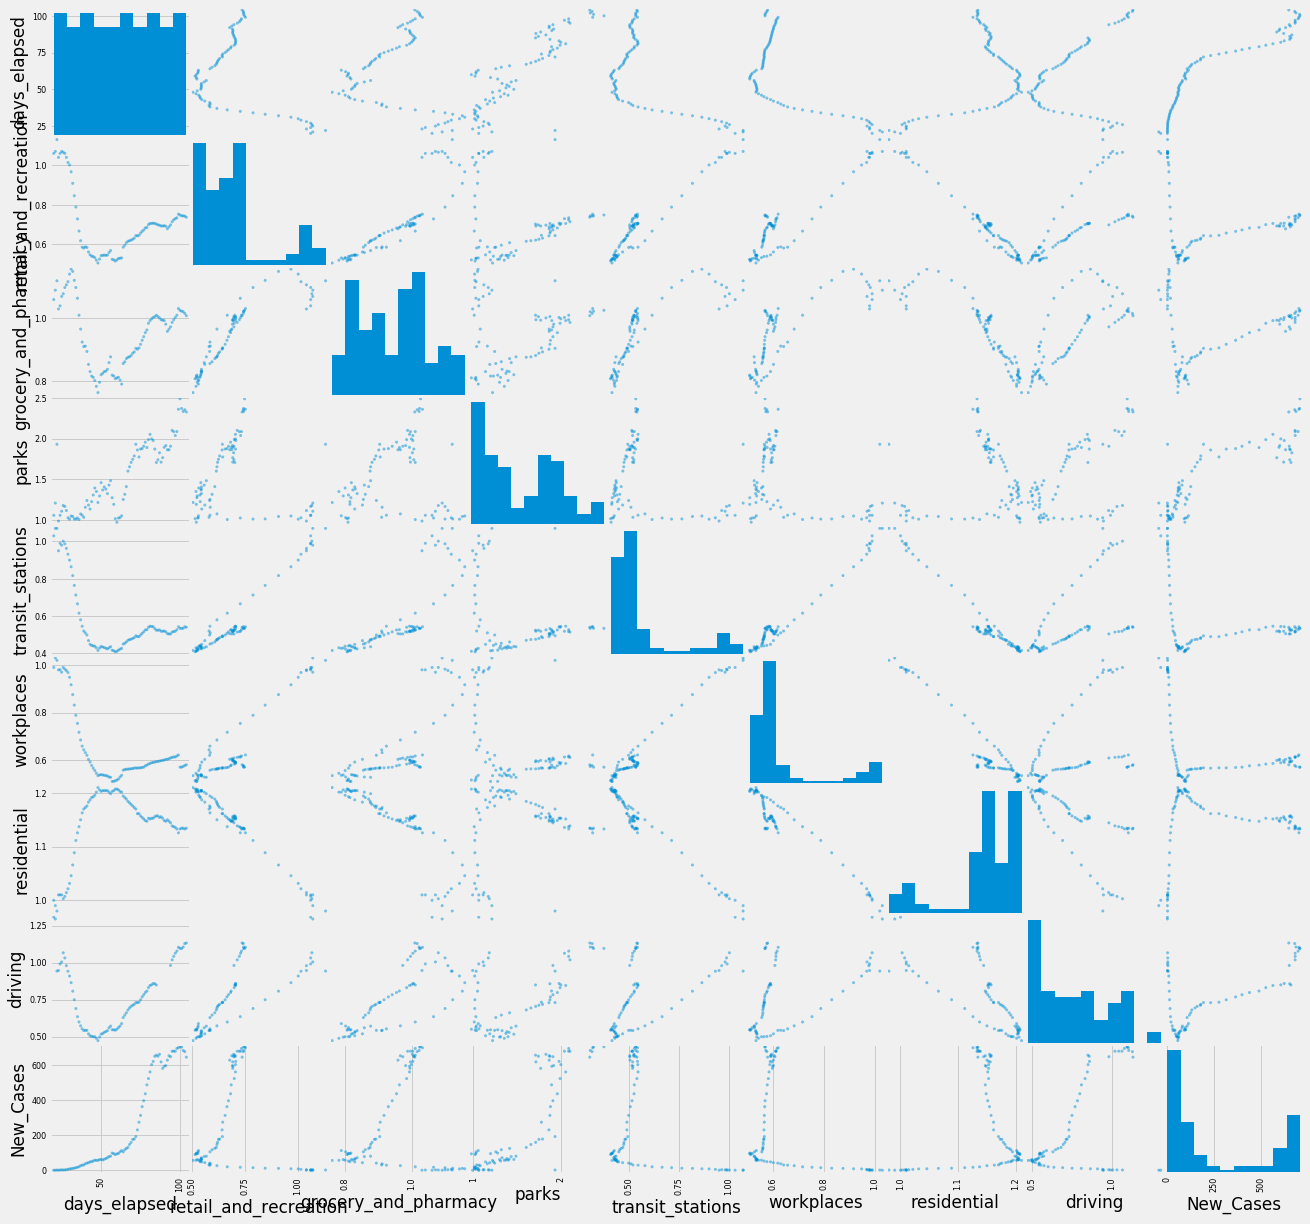

In [35]:
from pandas.plotting import scatter_matrix
scatter_matrix(Minnesota_Analysis.df, figsize = (20,20))

In [686]:
Min_y = Minnesota_Analysis.ts_df.pop('Daily New Cases(t)')

In [692]:
rf_model = NY_rf
predicted_df = generate_prediction_df('High',Minnesota_Analysis.ts_df, Min_y)[0]

In [510]:
NY_pop_density

356.34623774172854

In [688]:
NY_rf.model.predict(Minnesota_Analysis.ts_df)

array([155.39741204, 157.21806182, 157.60973374, 157.68196892,
       157.68196892, 157.79609021, 163.52486146, 167.33363201,
       157.8616383 , 157.67528183, 157.67528183, 157.67528183,
       157.67528183, 157.37223212, 154.87677498, 146.90430418,
       158.0172048 , 158.08943998, 157.47092169, 156.73791468,
       155.04953683, 149.47853661, 152.15983583, 145.87162774,
       142.51904843, 138.99238454, 138.95652415, 138.95652415,
       138.02385999, 138.02385999, 138.02385999, 138.02385999,
       138.02385999, 138.02385999, 138.02385999, 138.02385999,
       138.02385999, 138.02385999, 138.02385999, 138.02385999,
       138.06280673, 138.06280673, 138.19640139, 138.3910616 ,
       139.11473608, 139.46643248, 139.55182137, 139.56019859,
       139.36553838, 139.17087817, 138.81528711, 138.54148419,
       138.563603  , 139.11473608, 139.38016178, 139.55182137,
       139.56019859, 139.56019859, 139.6539647 , 139.66234192,
       139.66234192, 139.66234192, 139.66234192, 139.66

In [81]:
covid_raw_case = load_and_clean_data(False)

In [667]:
NY_raw = covid_raw_case[covid_raw_case['state'] == 'New York']
MN_raw = covid_raw_case[covid_raw_case['state'] == 'Minnesota']

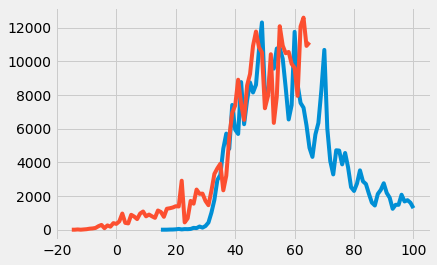

In [668]:
plt.plot(NY_raw['days_elapsed'], NY_raw['New_Cases'] )
plt.plot(MN_raw['days_elapsed'] - 35, 15 * MN_raw['New_Cases'])

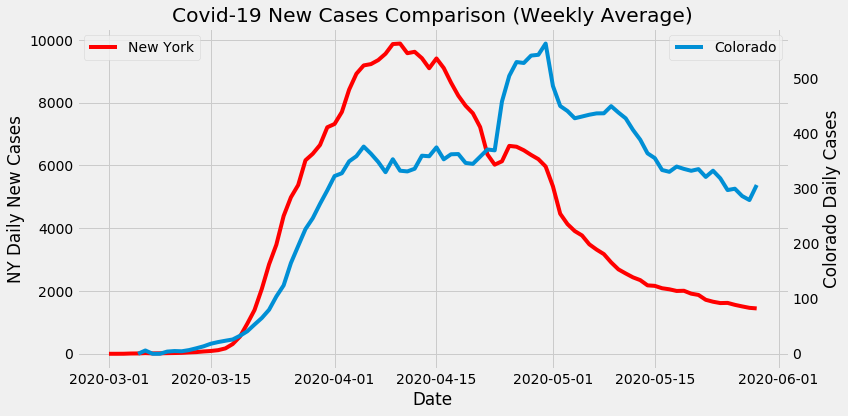

In [669]:
Colorado_Analysis = other_state('Colorado')
Colorado_Analysis.plot_vs_NY()

In [24]:
rule = rrulewrapper(DAILY, interval=7)
loc = RRuleLocator(rule)
formatter = DateFormatter('%y/%m/%d')

In [671]:
#Import and clean covid data (Cases in 2020)
covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
covid_df = clean_data(covid_raw_df, datetime_col='date')
covid_df.sort_values(['state', 'date'], inplace=True)
covid_df['New_Cases'] = covid_df['cases'].diff()

covid_df = replace_initial_values(covid_df, 'state', 'New_Cases')

In [672]:
covid_df
    #Load data, select only New York for now
covid_df = load_and_clean_data()
mask1 = (covid_df['state'] == 'New York')
NY_df = covid_df[mask1]
y = NY_df.pop('New_Cases_per_pop')
X = NY_df.iloc[:, 1: -1]

In [673]:
NY_Pop = 19440469/ 1000000

In [674]:
covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
covid_df = covid_raw_df[['date', 'state', 'cases']].copy()
# NY_df = covid_df[covid['state'] == 'New York']

covid_df.sort_values(['state', 'date'], inplace=True)
covid_df['New_Cases'] = covid_df['cases'].diff()

covid_df = replace_initial_values(covid_df, 'state', 'New_Cases')
mask1 = (covid_df['state'] == 'New York')
NY_df = covid_df[mask1]

> <ipython-input-659-b4bca5a16a78>(124)plot_model()
-> x = pd.DataFrame(x).iloc[:, 0].apply(convert_to_date)
(Pdb) c


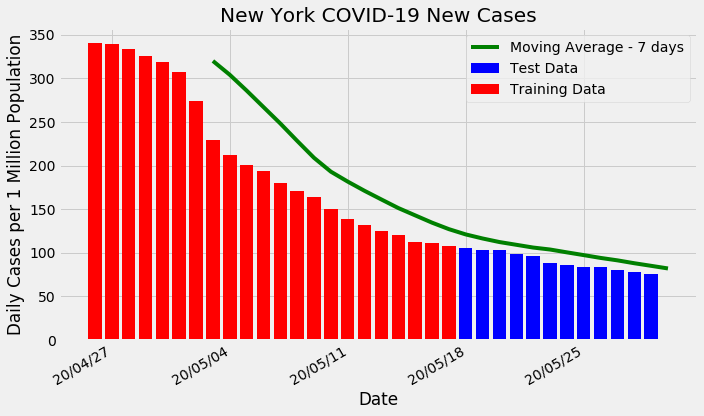

In [675]:
NY_rf.plot_model()

In [676]:
covid_raw_pop = load_and_clean_data(new_cases_per_pop = False)

In [14]:
predicted_df

,Daily New Cases(t-21),Daily New Cases(t-20),Daily New Cases(t-19),Daily New Cases(t-18),Daily New Cases(t-17),Daily New Cases(t-16),Daily New Cases(t-15),Daily New Cases(t-14),Daily New Cases(t-13),Daily New Cases(t-12),...,Daily New Cases(t-2),Daily New Cases(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t)
21,458.888106,472.519464,474.701951,481.264109,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,...,309.891113,315.431837,71.0,0.384286,0.768571,0.722857,0.321429,0.450000,1.235714,0.522500
22,472.519464,474.701951,481.264109,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,...,315.431837,340.666384,72.0,0.382857,0.764286,0.712857,0.318571,0.451429,1.235714,0.525543
23,474.701951,481.264109,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,...,340.666384,339.299574,73.0,0.394286,0.778571,0.834286,0.331429,0.457143,1.230000,0.546614
24,481.264109,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,...,339.299574,333.494306,74.0,0.388571,0.768571,0.735714,0.322857,0.455714,1.231429,0.539600
25,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,...,333.494306,325.859275,75.0,0.388571,0.768571,0.710000,0.322857,0.457143,1.231429,0.539729
26,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,...,325.859275,318.944392,76.0,0.401429,0.785714,0.802857,0.332857,0.461429,1.218571,0.556957
27,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,...,318.944392,306.900297,77.0,0.407143,0.785714,0.804286,0.334286,0.462857,1.217143,0.561171
28,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,...,306.900297,274.515717,78.0,0.410000,0.784286,0.785714,0.334286,0.464286,1.217143,0.564900
29,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,...,274.515717,229.513863,79.0,0.421429,0.798571,0.817143,0.342857,0.468571,1.212857,0.577600
30,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,...,229.513863,212.509570,80.0,0.430000,0.805714,0.842857,0.348571,0.472857,1.211429,0.588371


In [18]:
X_axis

array([datetime.date(2020, 5, 4), datetime.date(2020, 5, 5),
       datetime.date(2020, 5, 6), datetime.date(2020, 5, 7),
       datetime.date(2020, 5, 8), datetime.date(2020, 5, 9),
       datetime.date(2020, 5, 10), datetime.date(2020, 5, 11),
       datetime.date(2020, 5, 12), datetime.date(2020, 5, 13),
       datetime.date(2020, 5, 14), datetime.date(2020, 5, 15),
       datetime.date(2020, 5, 16), datetime.date(2020, 5, 17),
       datetime.date(2020, 5, 18), datetime.date(2020, 5, 19),
       datetime.date(2020, 5, 20), datetime.date(2020, 5, 21),
       datetime.date(2020, 5, 22), datetime.date(2020, 5, 23),
       datetime.date(2020, 5, 24), datetime.date(2020, 5, 25),
       datetime.date(2020, 5, 26), datetime.date(2020, 5, 27),
       datetime.date(2020, 5, 28), datetime.date(2020, 5, 29),
       datetime.date(2020, 5, 30), datetime.date(2020, 5, 31),
       datetime.date(2020, 6, 1), datetime.date(2020, 6, 2),
       datetime.date(2020, 6, 3), datetime.date(2020, 6, 4),
  

In [26]:
rf_model = NY_rf
last_params = [0.548571, 0.915714, 1.372857, 0.412857, 0.518571, 1.175714, 0.859657]
predicted_df, pred_y = generate_prediction_df(last_params, NY_ts_df, NY_ts_y)

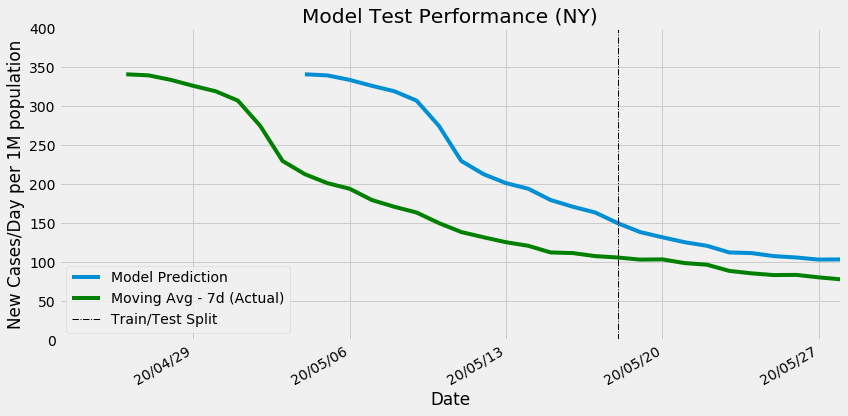

In [45]:
# prediction_ts_hi = generate_prediction_df('High', rf_model.X_test, rf_model.y_test, revised_df.columns)
# prediction_ts_hi['moving_average(t+20)'] = rf_model.model.predict(prediction_ts_hi)

# prediction_ts_md = generate_prediction_df('Medium', rf_model.X_test, rf_model.y_test, revised_df.columns)
# prediction_ts_md['moving_average(t+20)'] = rf_model.model.predict(prediction_ts_md)
fig, ax = plt.subplots(figsize = (12, 6))
X_axis = predicted_df['days_elapsed(t)'].apply(convert_to_date).values
X_axis = X_axis[-len(pred_y):]
# replace_with_moving_averages
ax.plot(X_axis, pred_y, label = 'Model Prediction')
# ax.plot(prediction_ts_hi['days_elapsed(t+20)'].apply(convert_to_date) ,prediction_ts_hi['moving_average(t+20)'], label = 'High Social Distance')
# ax.plot(prediction_ts_md['days_elapsed(t+20)'].apply(convert_to_date) ,prediction_ts_md['moving_average(t+20)'], label = 'Medium Social Distance')
# ax.plot(prediction_ts_lw['days_elapsed(t+20)'].apply(convert_to_date) ,prediction_ts_lw['moving_average(t+20)'], label = 'Low Social Distance')
# ax.legend()

# ax.plot(covid_df[covid_df['state']== 'New York']['date'], covid_df[covid_df['state']== 'New York']['New_Cases']/ NY_Pop, label = 'Actual')

# NY_df['days_elapsed'] = NY_df['days_elapsed'].apply(convert_to_date)
# NY_df.rename(columns = {'days_elapsed': 'date'}, inplace = True)
ax.plot(NY_ts_df['days_elapsed(t)'].apply(convert_to_date), NY_ts_y, c = 'green', label = 'Moving Avg - 7d (Actual)')
ax.set_title('Model Test Performance (NY)')
ax.set_xlabel('Date')
ax.set_ylabel('New Cases/Day per 1M population')
ax.set_xlim(datetime.date(2020, 4, 23), datetime.date(2020, 5, 28))
ax.set_ylim(0, 400)

ax.axvline(convert_to_date(93), label = 'Train/Test Split', ls = '-.', lw = 1, c='black')
ax.legend()

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=14)
fig.autofmt_xdate()
fig.tight_layout()

In [37]:
convert_to_date(94)

datetime.date(2020, 5, 19)

(array([737485., 737499., 737516., 737530., 737546., 737560., 737577.]),
 <a list of 7 Text xticklabel objects>)

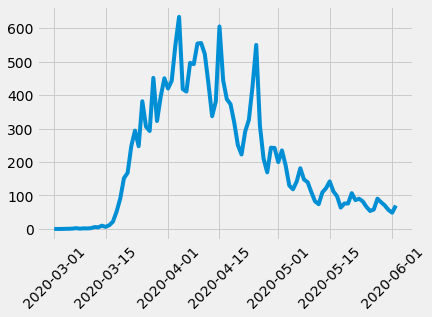

In [195]:

plt.xticks(rotation=45)

In [38]:
convert_to_date(93)

datetime.date(2020, 5, 18)

In [96]:
rf_model.X_train

,Daily New Cases(t-21),Daily New Cases(t-20),Daily New Cases(t-19),Daily New Cases(t-18),Daily New Cases(t-17),Daily New Cases(t-16),Daily New Cases(t-15),Daily New Cases(t-14),Daily New Cases(t-13),Daily New Cases(t-12),...,Daily New Cases(t-2),Daily New Cases(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t)
21,458.888106,472.519464,474.701951,481.264109,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,...,309.891113,315.431837,71.0,0.384286,0.768571,0.722857,0.321429,0.450000,1.235714,0.522500
22,472.519464,474.701951,481.264109,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,...,315.431837,340.666384,72.0,0.382857,0.764286,0.712857,0.318571,0.451429,1.235714,0.525543
23,474.701951,481.264109,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,...,340.666384,339.299574,73.0,0.394286,0.778571,0.834286,0.331429,0.457143,1.230000,0.546614
24,481.264109,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,...,339.299574,333.494306,74.0,0.388571,0.768571,0.735714,0.322857,0.455714,1.231429,0.539600
25,491.669502,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,...,333.494306,325.859275,75.0,0.388571,0.768571,0.710000,0.322857,0.457143,1.231429,0.539729
26,507.520090,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,...,325.859275,318.944392,76.0,0.401429,0.785714,0.802857,0.332857,0.461429,1.218571,0.556957
27,508.357812,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,...,318.944392,306.900297,77.0,0.407143,0.785714,0.804286,0.334286,0.462857,1.217143,0.561171
28,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,...,306.900297,274.515717,78.0,0.410000,0.784286,0.785714,0.334286,0.464286,1.217143,0.564900
29,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,...,274.515717,229.513863,79.0,0.421429,0.798571,0.817143,0.342857,0.468571,1.212857,0.577600
30,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,...,229.513863,212.509570,80.0,0.430000,0.805714,0.842857,0.348571,0.472857,1.211429,0.588371


In [79]:
fig.savefig('images/predicted_vs_actual')

In [305]:
from matplotlib.dates import (DAILY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)

rule = rrulewrapper(DAILY, interval=7)
loc = RRuleLocator(rule)
formatter = DateFormatter('%y/%m/%d')

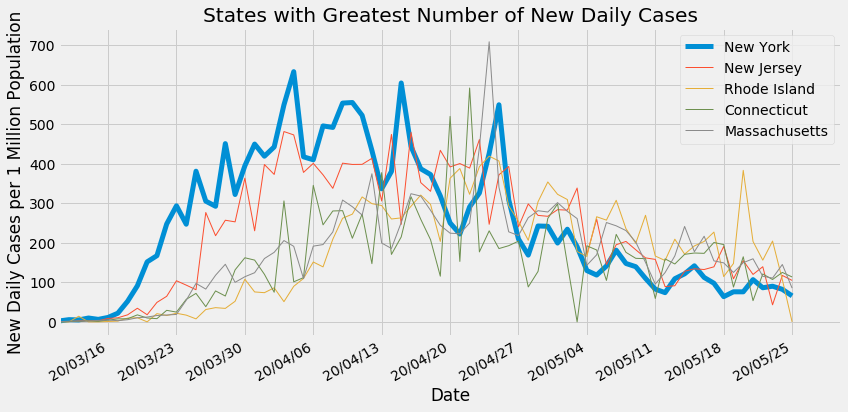

In [311]:
num_states = 5
i = 0

top_states = covid_df[['state','New_Cases_per_pop']].groupby('state').mean()
top_states.sort_values('New_Cases_per_pop', ascending = False, inplace = True)
fig, axes = plt.subplots(figsize = (12,6))
lw = [5] + [1] * (num_states -1)
for state in top_states.index[:num_states]:
    x = covid_df[covid_df['state'] == state].loc[:, 'days_elapsed']
    x = x.apply(convert_to_date)
    y = covid_df[covid_df['state'] == state].loc[:, 'New_Cases_per_pop']
    axes.plot_date(x,y, label = state, linewidth = lw[i], xdate = True, ls = '-', marker = '')
    fig.autofmt_xdate()
    i += 1
axes.legend()

axes.set_xlabel('Date')
axes.set_ylabel('New Daily Cases per 1 Million Population')
axes.set_title('States with Greatest Number of New Daily Cases')

axes.xaxis.set_major_locator(loc)
axes.xaxis.set_major_formatter(formatter)
axes.xaxis.set_tick_params(rotation=30, labelsize=14)
start_x = convert_to_date(25)
axes.set_xlim(start_x)
fig.tight_layout()

In [21]:
x.iloc[0]

datetime.date(2020, 2, 15)

In [93]:
fig.savefig('images/Top5States')

In [240]:
NY_df

,state,days_elapsed,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving,pop_density,New_Cases_per_pop
2561,New York,15,1.10,1.05,1.09,1.00,1.03,0.99,0.9934,356.346238,0.000000
2562,New York,16,1.06,1.05,1.16,0.99,1.04,1.00,1.0288,356.346238,0.000000
2563,New York,17,1.04,1.06,1.06,1.00,1.04,1.00,1.0594,356.346238,0.051439
2564,New York,18,1.07,1.08,1.16,1.00,1.03,1.00,1.0839,356.346238,0.462952
2565,New York,19,1.08,1.09,1.21,1.00,1.04,0.99,1.1334,356.346238,0.565830
...,...,...,...,...,...,...,...,...,...,...,...
2642,New York,96,0.58,0.96,1.39,0.42,0.49,1.20,0.9018,356.346238,106.890425
2643,New York,97,0.55,0.94,1.19,0.43,0.50,1.21,1.0015,356.346238,86.314790
2644,New York,98,0.50,0.88,1.00,0.42,0.68,1.12,0.8392,356.346238,90.224161
2645,New York,99,0.57,0.93,1.93,0.48,0.71,1.07,0.8336,356.346238,82.353980


In [249]:
all_states = covid_raw_df['state'].unique()

In [255]:
def raw_state_data(states):
    covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
    state_raw_list = []
    for state in states:
        state_raw_list.append(covid_raw_df[covid_raw_df['state'] == state])
    return state_raw_list

In [259]:
CO_df = raw_state_data(['Colorado'])[0]
MI_df = raw_state_data(['Michigan'])[0]

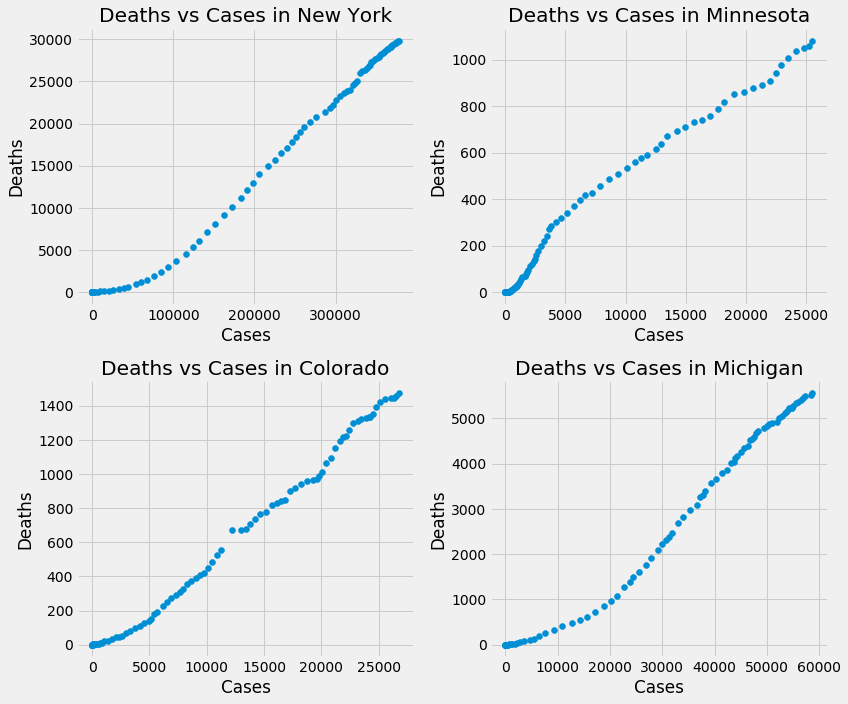

In [261]:
fig, axes = plt.subplots(2, 2, figsize = (12,10))
state_df = (NY_raw, MN_raw, CO_df, MI_df)
state = ('New York', 'Minnesota', 'Colorado', 'Michigan')
for i, ax in enumerate(axes.flatten()):
    ax.scatter(state_df[i]['cases'], state_df[i]['deaths'])
    ax.set_title('Deaths vs Cases in {}'.format(state[i]))
    ax.set_xlabel('Cases')
    ax.set_ylabel('Deaths')
fig.tight_layout()
# Mostly linear trend between cases and deaths
fig.savefig('images/DeathVsCases')

In [95]:
revised_df.rename(columns = {'moving_average': 'Daily New Cases'}, inplace = True)

Text(0.5, 0, 'Date')

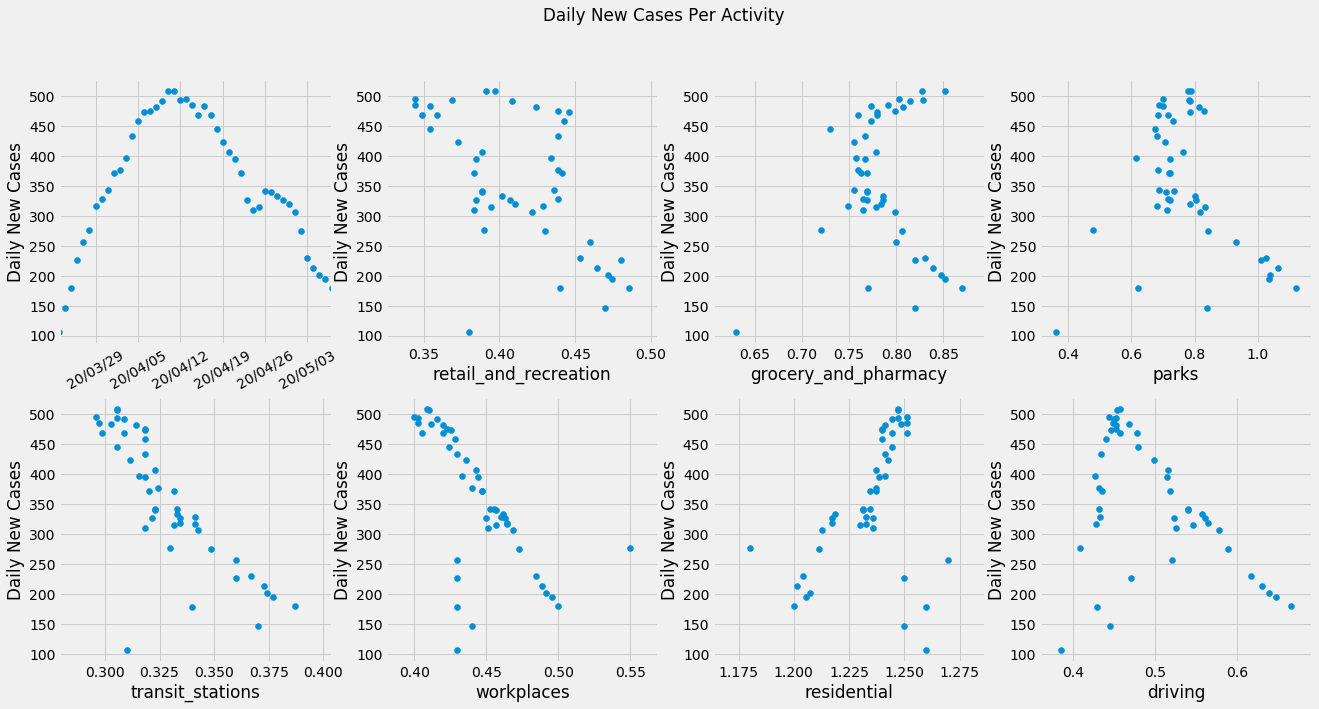

In [96]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10), sharey = False)
y_vals = revised_df['Daily New Cases']
cols = revised_df.columns[:9]

axes.flatten()[0].scatter(revised_df[cols[0]].apply(convert_to_date), y_vals)
axes.flatten()[0].xaxis.set_major_locator(loc)
axes.flatten()[0].xaxis.set_major_formatter(formatter)
axes.flatten()[0].xaxis.set_tick_params(rotation=30, labelsize=14)
start_x = convert_to_date(revised_df['days_elapsed'].min())
end_x = convert_to_date(revised_df['days_elapsed'].max())
axes.flatten()[0].set_xlim(start_x, end_x)
axes.flatten()[0].set_xlabel(cols[i])
axes.flatten()[0].set_ylabel('Daily New Cases')

i = 1
for ax in axes.flatten()[1:]:
    ax.scatter(revised_df[cols[i]], y_vals)
    ax.set_xlabel(cols[i])
    ax.set_ylabel('Daily New Cases')
    i += 1
fig.suptitle('Daily New Cases Per Activity')
axes.flatten()[0].set_xlabel('Date')

In [97]:
fig.savefig('images/CasesperActivit')

In [554]:
#threshold = 100
X.rename(columns = {'days_elapsed': 'days_elapsed(t)'}, inplace = True)
rf_model = reg_model(X, y, log_trans_y = True)
NY_New_Cases = rf_model.plot_model(save_name = 'NY_New_100', xvar = 'days_elapsed(t)', convDate = True)

NameError: name 'X' is not defined

In [50]:
from pandas.plotting import scatter_matrix

In [157]:
sm = revised_df.drop('pop_density', axis = 1)

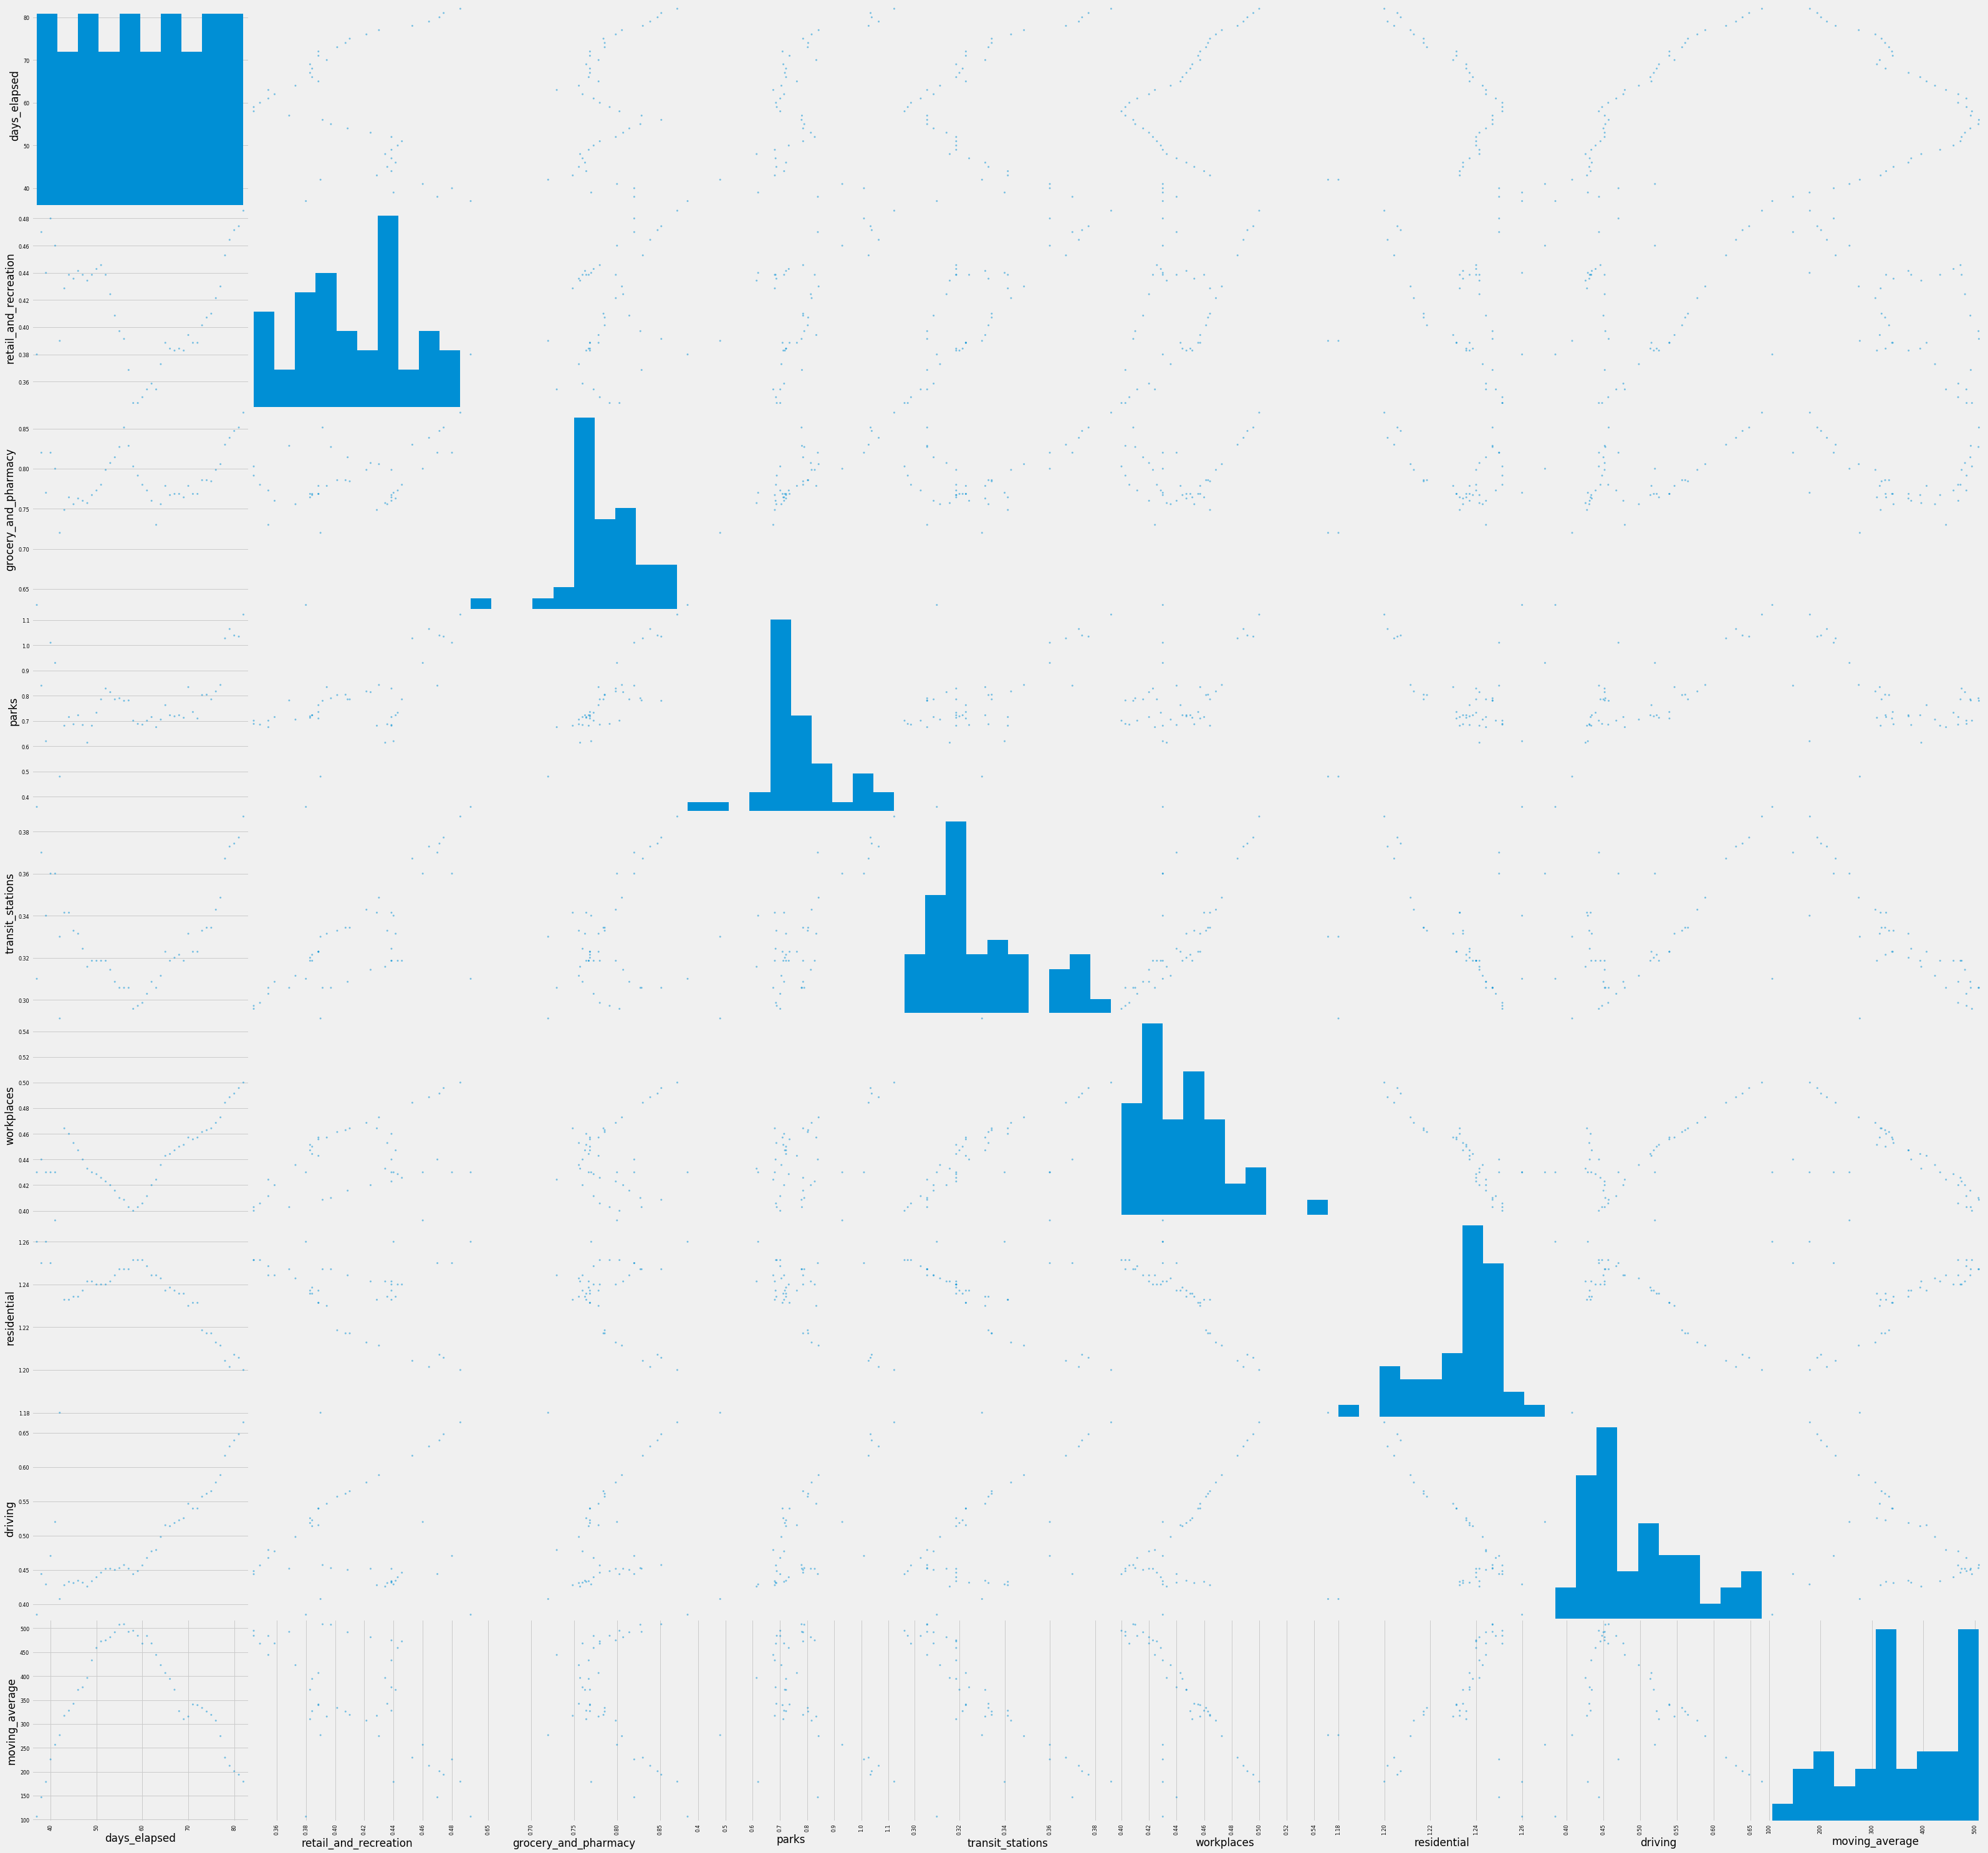

In [84]:
scatter100 = scatter_matrix(sm, figsize = (50,50))

In [86]:
plt.savefig('images/scatter100')

<Figure size 432x288 with 0 Axes>

In [ ]:
X.rename(columns = {'days_elapsed': 'days_elapsed(t)'}, inplace = True)

In [ ]:
#300 Threshold
rf_model = reg_model(X,y, log_trans_y = True)
NY_New_Cases = rf_model.plot_model(save_name = 'NY_New_300', xvar = 'days_elapsed(t)')

In [124]:

X

,days_elapsed(t),retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving
2003,15,1.10,1.05,1.09,1.00,1.03,0.99,0.9934
2004,16,1.06,1.05,1.16,0.99,1.04,1.00,1.0288
2005,17,1.04,1.06,1.06,1.00,1.04,1.00,1.0594
2006,18,1.07,1.08,1.16,1.00,1.03,1.00,1.0839
2007,19,1.08,1.09,1.21,1.00,1.04,0.99,1.1334
...,...,...,...,...,...,...,...,...
2066,78,0.50,0.84,1.71,0.43,0.64,1.10,0.6245
2067,79,0.49,0.83,0.89,0.36,0.45,1.23,0.6243
2068,80,0.51,0.91,1.04,0.37,0.45,1.22,0.6745
2069,81,0.46,0.84,0.70,0.35,0.45,1.24,0.6365


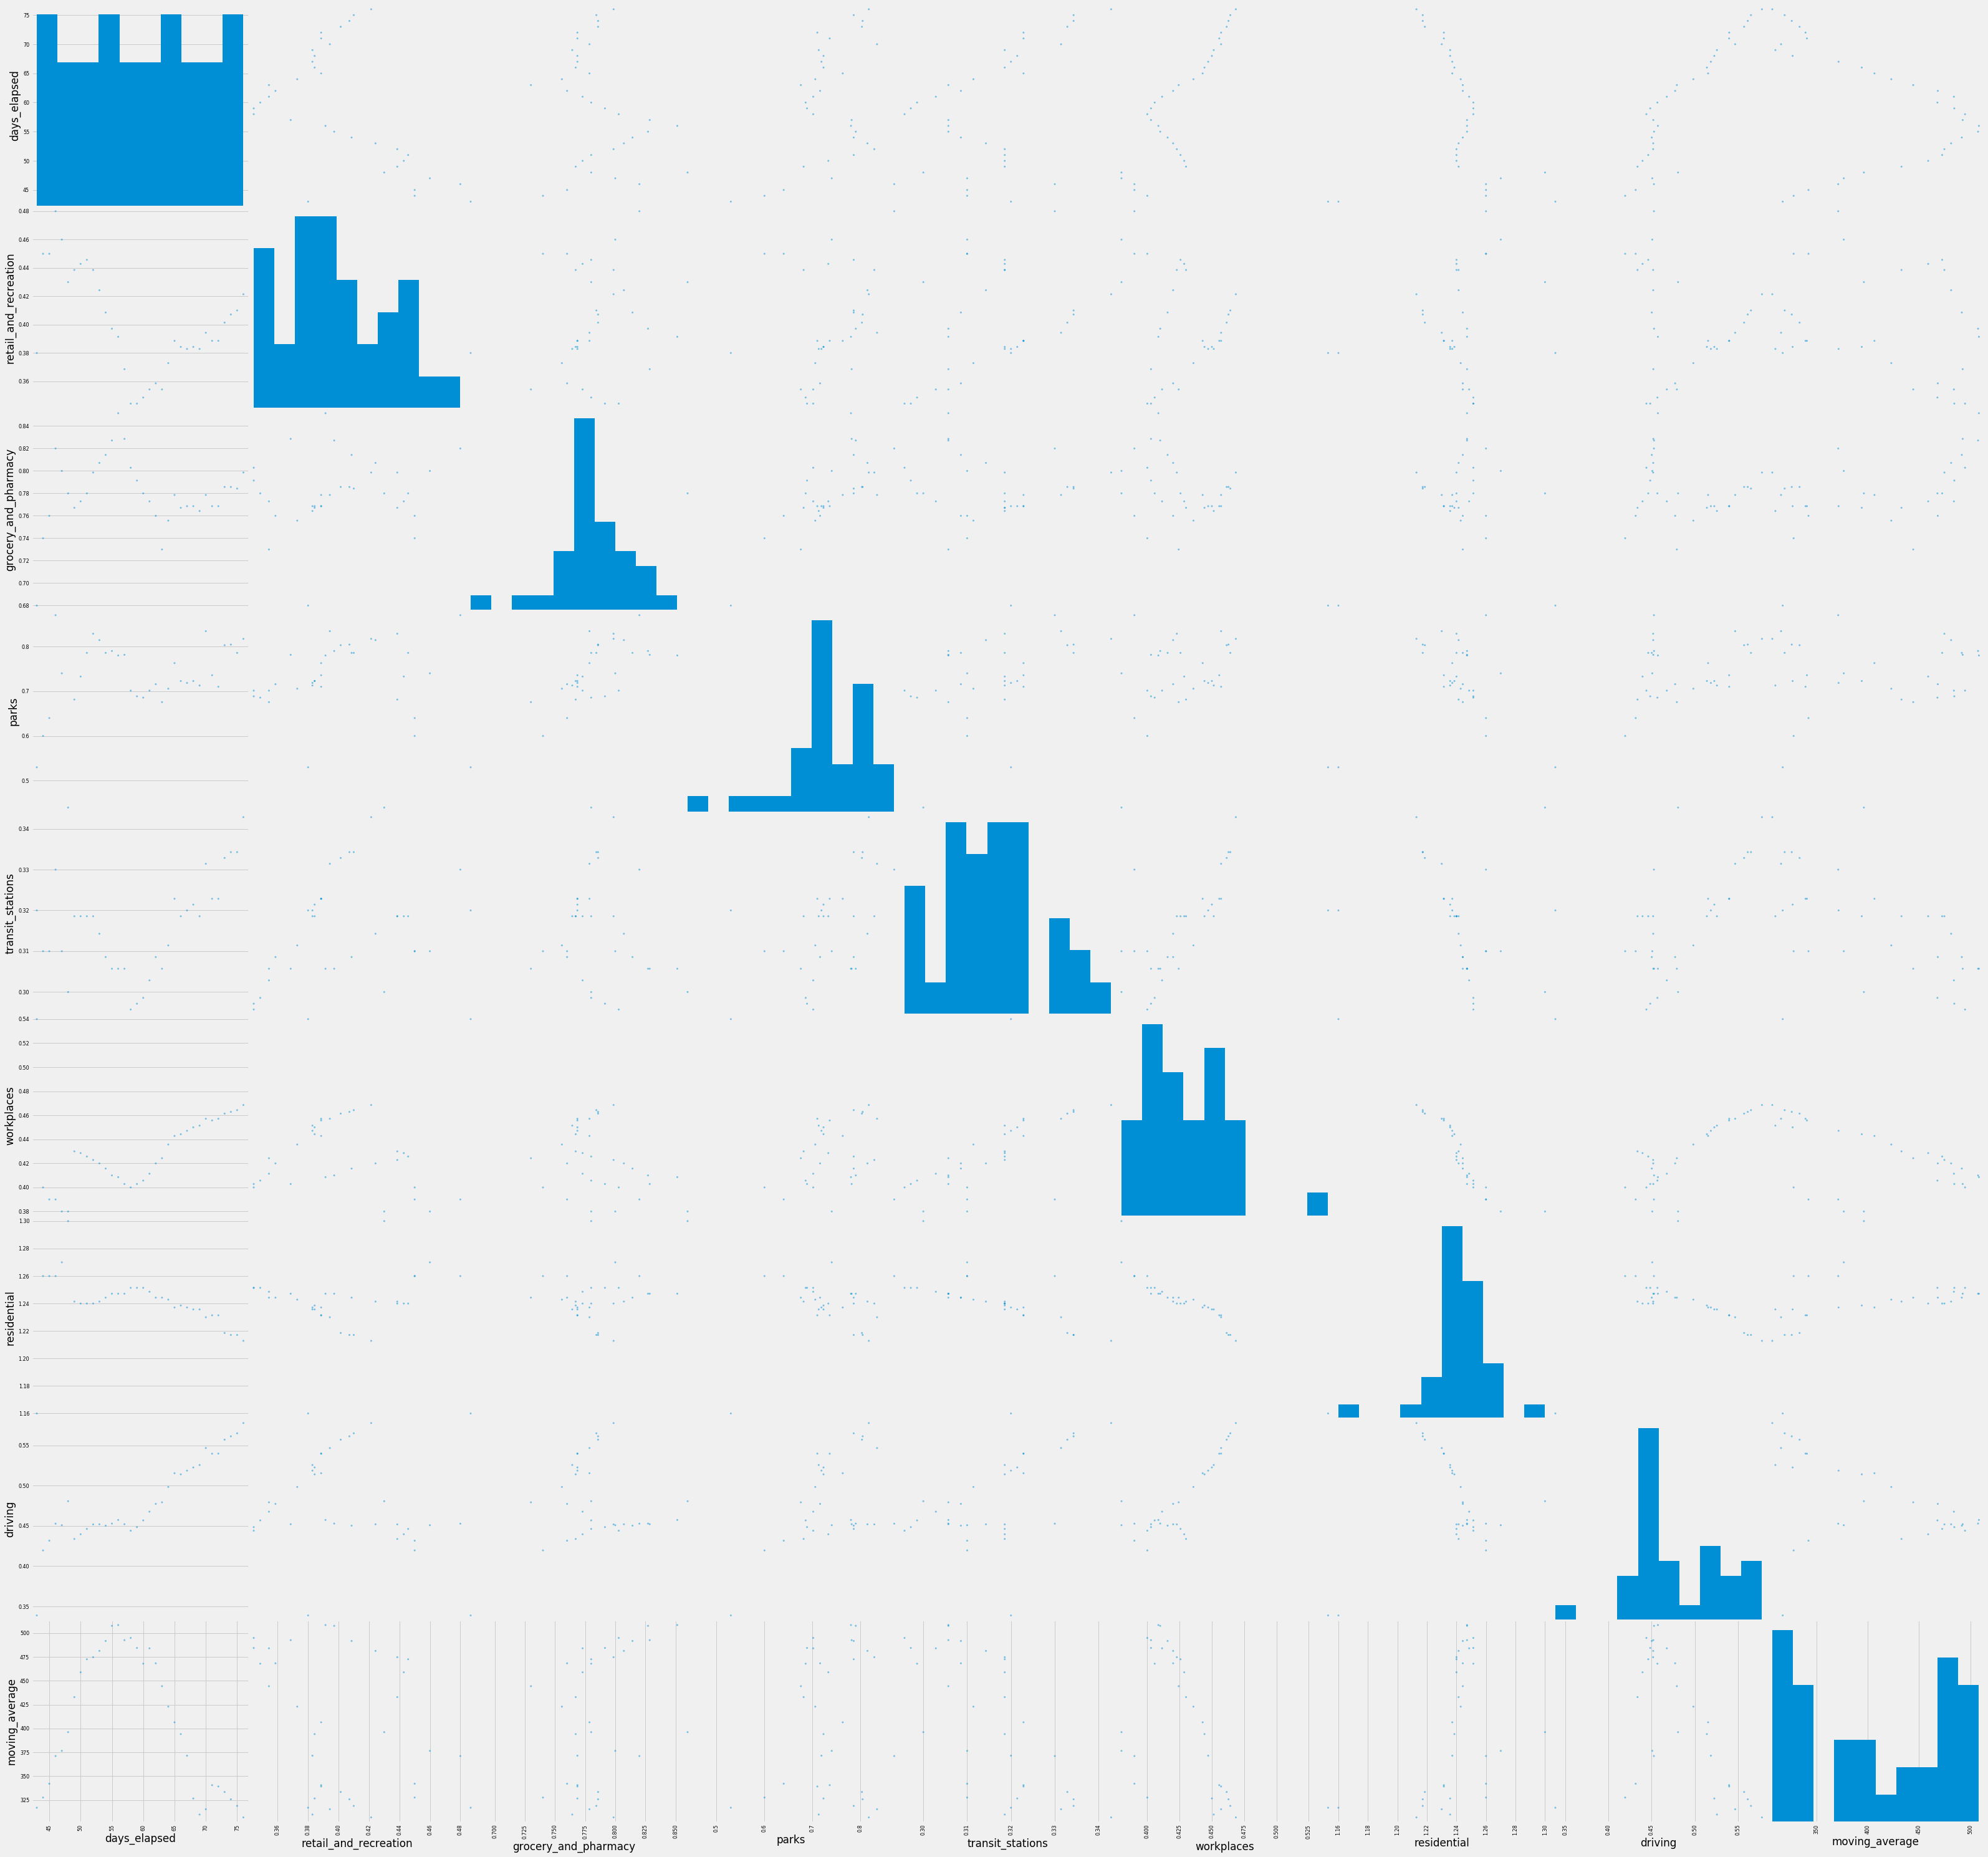

In [148]:
#Using 300 threshold
sm = revised_df.drop('pop_density', axis = 1)
scatter300 = scatter_matrix(sm, figsize = (50,50))

Text(0.5, 0.98, 'Daily New Cases Per Activity (300 Threshold)')

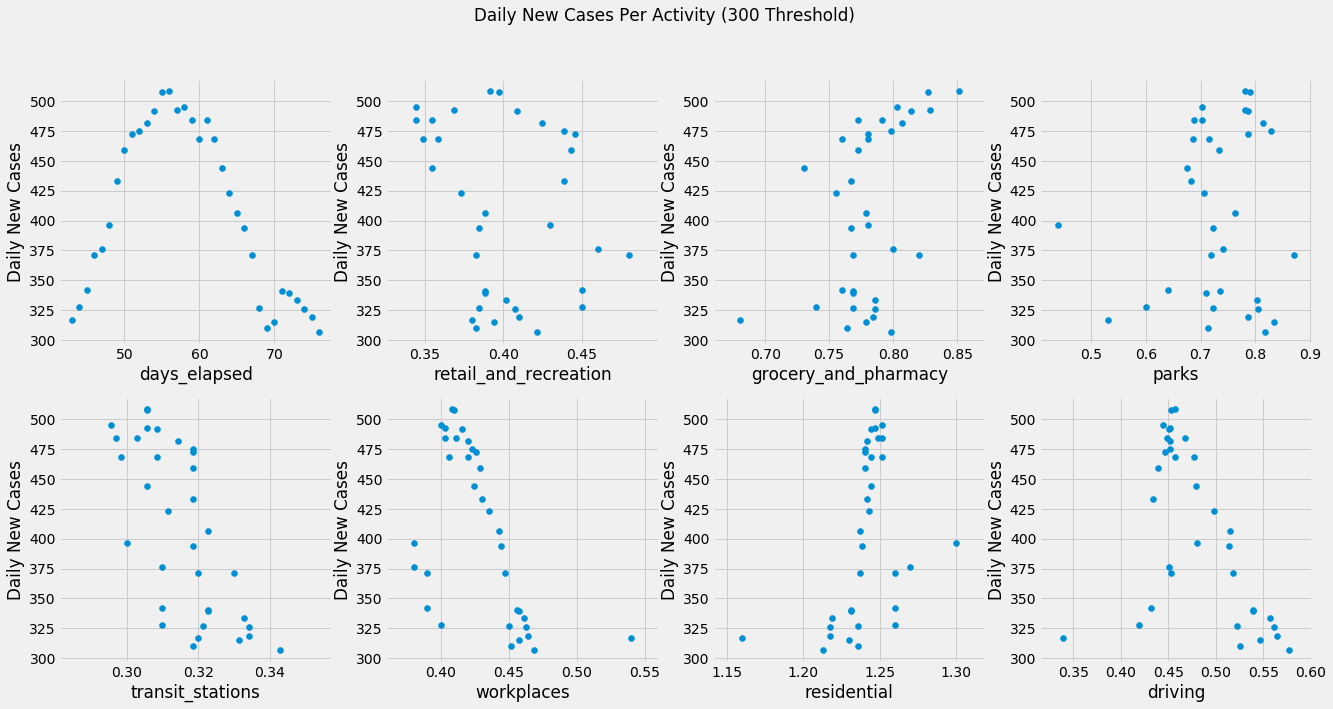

In [64]:
#Using 300 threshold
revised_df.rename(columns = {'moving_average': 'Daily New Cases'}, inplace = True)
fig, axes = plt.subplots(2, 4, figsize = (20, 10))
y_vals = revised_df['Daily New Cases']
cols = revised_df.columns[:9]
i = 0
for ax in axes.flatten():
    ax.scatter(revised_df[cols[i]], y_vals)
    ax.set_xlabel(cols[i])
    ax.set_ylabel('Daily New Cases')
    i += 1
fig.suptitle('Daily New Cases Per Activity (300 Threshold)')

In [66]:
fig.savefig('images/NYSocialDistanceplots.png')

In [14]:
plot_df = revised_df.copy()
plot_df.rename(columns = {'moving_average': "New Cases"})
# plot_df.drop('pop_density', axis = 1, inplace = True)
for col in plot_df.columns[1:]:
    max_val = plot_df[col].max()
    plot_df.loc[:,col] = plot_df[col]/max_val

In [19]:
plot_df.rename(columns = {'moving_average': 'Daily New Cases'}, inplace = True)

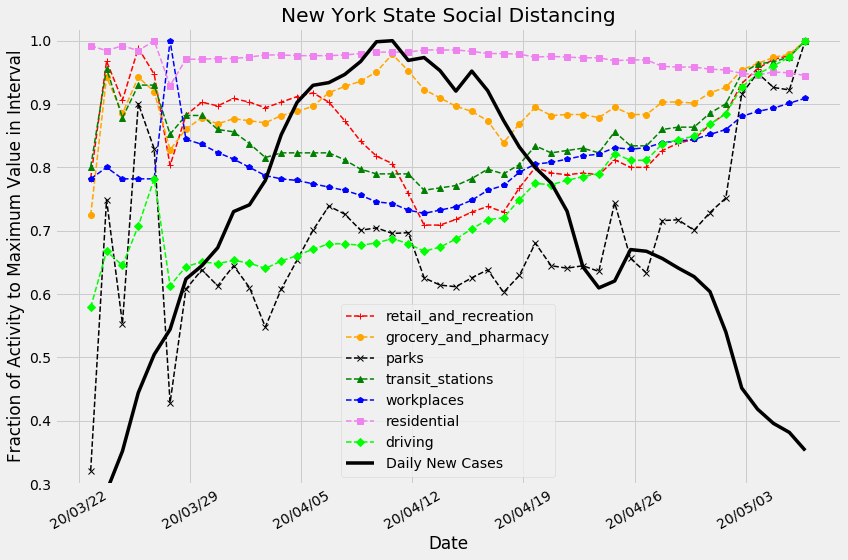

In [23]:
fig, ax = plt.subplots(figsize = (12, 8))
linestyles = ['--', '--', '--', '--', '--', '--', '--', '-']
linewidths = [1.5, 1.5, 1.5, 1.5, 1.5 ,1.5 ,1.5, 3.5]
markers = list('+ox^psD ')
colors = ['red', 'orange', 'black', 'green', 'blue', 'violet', 'lime', 'black']
for i, col in enumerate(plot_df.columns[1:]):
    ax.plot_date(plot_df['days_elapsed'].apply(convert_to_date), plot_df[col], label = col, ls = linestyles[i], linewidth = linewidths[i], c = colors[i], marker = markers[i])
ax.legend()
ax.set_ylim(0.3, 1.02)
ax.set_title('New York State Social Distancing')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction of Activity to Maximum Value in Interval')

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=14)
# start_x = convert_to_date(25)
# axes.set_xlim(start_x)
fig.tight_layout()


In [25]:
fig.savefig('images/NY_Social_Distance_days')

In [73]:
predicted_df

,Daily New Cases(t-21),Daily New Cases(t-20),Daily New Cases(t-19),Daily New Cases(t-18),Daily New Cases(t-17),Daily New Cases(t-16),Daily New Cases(t-15),Daily New Cases(t-14),Daily New Cases(t-13),Daily New Cases(t-12),...,Daily New Cases(t-2),Daily New Cases(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t)
42,494.844029,470.711968,466.562304,459.616924,439.621889,420.286230,398.835469,378.583826,360.790458,328.761763,...,362.300857,368.545488,79.0,0.421429,0.798571,0.817143,0.342857,0.468571,1.212857,0.577600
43,484.350455,466.562304,459.616924,439.621889,420.286230,398.835469,378.583826,360.790458,328.761763,328.485829,...,368.545488,372.265269,80.0,0.430000,0.805714,0.842857,0.348571,0.472857,1.211429,0.588371
44,467.889946,459.616924,439.621889,420.286230,398.835469,378.583826,360.790458,328.761763,328.485829,332.839045,...,372.265269,377.373685,81.0,0.452857,0.830000,1.027143,0.367143,0.484286,1.204286,0.616614
45,483.960987,439.621889,420.286230,398.835469,378.583826,360.790458,328.761763,328.485829,332.839045,334.993902,...,377.373685,378.606166,82.0,0.464286,0.838571,1.064286,0.372857,0.488571,1.201429,0.630100
0,468.279414,420.286230,398.835469,378.583826,360.790458,328.761763,328.485829,332.839045,334.993902,338.475667,...,378.606166,409.801768,83.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,444.308799,398.835469,378.583826,360.790458,328.761763,328.485829,332.839045,334.993902,338.475667,337.693499,...,409.801768,415.594985,84.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,422.917486,378.583826,360.790458,328.761763,328.485829,332.839045,334.993902,338.475667,337.693499,340.382073,...,415.594985,419.084834,85.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,406.486372,360.790458,328.761763,328.485829,332.839045,334.993902,338.475667,337.693499,340.382073,343.962234,...,419.084834,420.528435,86.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,394.133642,328.761763,328.485829,332.839045,334.993902,338.475667,337.693499,340.382073,343.962234,349.760742,...,420.528435,423.120524,87.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,371.515140,328.485829,332.839045,334.993902,338.475667,337.693499,340.382073,343.962234,349.760742,357.520696,...,423.120524,423.288803,88.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000


AttributeError: 'reg_model' object has no attribute 'model'

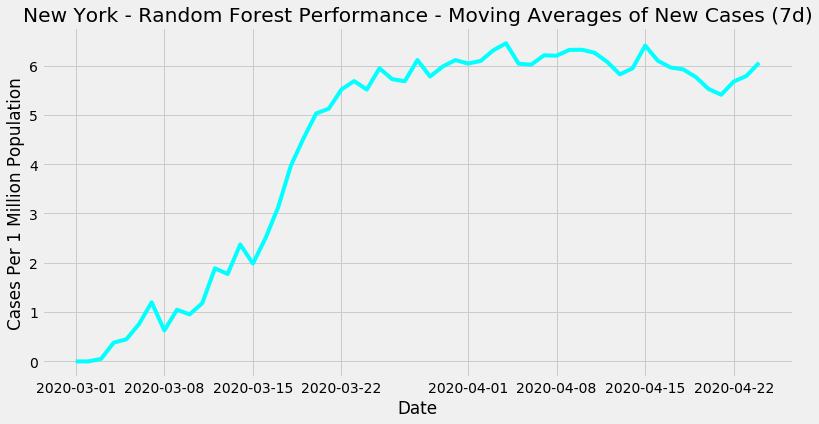

In [77]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot_date(rf_model.X_train['days_elapsed(t)'].apply(convert_to_date), rf_model.y_train, label = 'Training Data', color = 'cyan', marker = '', ls = '-')
# ax.plot_date(predicted_df['days_elapsed(t)'].apply(convert_to_date), predicted_df['Daily New Cases'], label = 'Actual New Cases', color = 'blue', marker = '', ls = '-')
# ax.plot_date(predicted_df['days_elapsed(t)'].apply(convert_to_date), pred_y, label = 'Predicted', color = 'red', marker = '', ls = '-')
# ax.plot_date(rf_model.X_train['days_elapsed(t)'].apply(convert_to_date), rf_model.model.predict(rf_model.X_train), label = 'Training Predictions', color = 'orange', marker = '', ls = '-')
ax.set_xlabel('Date')
ax.set_ylabel('Cases Per 1 Million Population')
ax.set_title('New York - Random Forest Performance - Moving Averages of New Cases (7d)')
rmse = 'Test RMSE:' + str(round(rf_model.evaluate_model(),1))
ax.text(convert_to_date(55), 90,rmse)
ax.legend()

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=14)
fig.autofmt_xdate()

In [16]:
fig.savefig('images/RF_Performance')

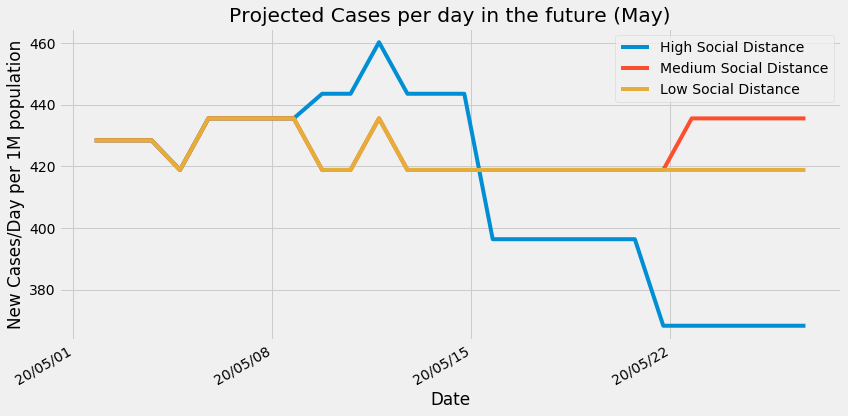

In [58]:
prediction_ts_hi = generate_prediction_df('High', rf_model.X_test, rf_model.y_test, revised_df.columns)
prediction_ts_hi['moving_average(t+20)'] = rf_model.model.predict(prediction_ts_hi)

prediction_ts_md = generate_prediction_df('Medium', rf_model.X_test, rf_model.y_test, revised_df.columns)
prediction_ts_md['moving_average(t+20)'] = rf_model.model.predict(prediction_ts_md)

prediction_ts_lw = generate_prediction_df('Low', rf_model.X_test, rf_model.y_test, revised_df.columns)
prediction_ts_lw['moving_average(t+20)'] = rf_model.model.predict(prediction_ts_lw)

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(prediction_ts_hi['days_elapsed(t+20)'].apply(convert_to_date) ,prediction_ts_hi['moving_average(t+20)'], label = 'High Social Distance')
ax.plot(prediction_ts_md['days_elapsed(t+20)'].apply(convert_to_date) ,prediction_ts_md['moving_average(t+20)'], label = 'Medium Social Distance')
ax.plot(prediction_ts_lw['days_elapsed(t+20)'].apply(convert_to_date) ,prediction_ts_lw['moving_average(t+20)'], label = 'Low Social Distance')
ax.legend()
ax.set_title('Projected Cases per day in the future (May)')
ax.set_xlabel('Date')
ax.set_ylabel('New Cases/Day per 1M population')

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=14)
fig.autofmt_xdate()
fig.tight_layout()

In [4]:
fig.savefig('images/Predictions')

NameError: name 'fig' is not defined

In [30]:
rf_model.X_train

,days_elapsed(t-20),retail_and_recreation(t-20),grocery_and_pharmacy(t-20),parks(t-20),transit_stations(t-20),workplaces(t-20),residential(t-20),driving(t-20),Daily New Cases(t-20),days_elapsed(t-19),...,driving(t-1),Daily New Cases(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t)
20,37.0,0.380000,0.630000,0.360000,0.310000,0.430000,1.260000,0.385000,106.229066,38.0,...,0.457329,508.357812,57.0,0.368571,0.828571,0.781429,0.305714,0.402857,1.247143,0.452029
21,38.0,0.470000,0.820000,0.840000,0.370000,0.440000,1.250000,0.444200,146.594053,39.0,...,0.452029,492.543967,58.0,0.344286,0.802857,0.701429,0.295714,0.400000,1.251429,0.444000
22,39.0,0.440000,0.770000,0.620000,0.340000,0.430000,1.260000,0.429100,178.772877,40.0,...,0.444000,494.844029,59.0,0.344286,0.791429,0.688571,0.297143,0.402857,1.251429,0.448429
23,40.0,0.480000,0.820000,1.010000,0.360000,0.430000,1.250000,0.470600,225.810249,41.0,...,0.448429,484.350455,60.0,0.348571,0.780000,0.685714,0.298571,0.405714,1.251429,0.456743
24,41.0,0.460000,0.800000,0.930000,0.360000,0.430000,1.270000,0.520100,256.431203,42.0,...,0.456743,467.889946,61.0,0.354286,0.772857,0.701429,0.302857,0.411429,1.248571,0.467614
25,42.0,0.390000,0.720000,0.480000,0.330000,0.550000,1.180000,0.407800,276.536538,43.0,...,0.467614,483.960987,62.0,0.358571,0.760000,0.715714,0.308571,0.420000,1.244286,0.477243
26,43.0,0.428571,0.748571,0.681429,0.341429,0.464286,1.232857,0.427943,317.048494,44.0,...,0.477243,468.279414,63.0,0.354286,0.730000,0.675714,0.305714,0.424286,1.244286,0.479214
27,44.0,0.438571,0.764286,0.715714,0.341429,0.460000,1.232857,0.432871,327.703734,45.0,...,0.479214,444.308799,64.0,0.372857,0.755714,0.705714,0.311429,0.435714,1.242857,0.498286
28,45.0,0.435714,0.755714,0.687143,0.332857,0.452857,1.234286,0.431071,342.165466,46.0,...,0.498286,422.917486,65.0,0.388571,0.778571,0.762857,0.322857,0.442857,1.237143,0.515329
29,46.0,0.441429,0.762857,0.722857,0.331429,0.447143,1.234286,0.434443,371.155067,47.0,...,0.515329,406.486372,66.0,0.384286,0.767143,0.722857,0.318571,0.444286,1.238571,0.513929


In [35]:
rf_model.y_test

33    315.431837
34    340.666384
35    339.299574
36    333.494306
37    325.859275
38    318.944392
39    306.900297
40    274.515717
41    229.513863
42    212.509570
43    201.097441
44    193.873924
45    179.382798
Name: Daily New Cases(t), dtype: float64

In [10]:
new_revised_df

ValueError: Length mismatch: Expected axis has 9 elements, new values have 188 elements

In [28]:
test.head(7)

NameError: name 'test' is not defined

In [35]:
for each in test.columns:
    print(each)

days_elapsed(t)
retail_and_recreation(t)
grocery_and_pharmacy(t)
parks(t)
transit_stations(t)
workplaces(t)
residential(t)
driving(t)
moving_average(t)
days_elapsed(t+1)
retail_and_recreation(t+1)
grocery_and_pharmacy(t+1)
parks(t+1)
transit_stations(t+1)
workplaces(t+1)
residential(t+1)
driving(t+1)
moving_average(t+1)
days_elapsed(t+2)
retail_and_recreation(t+2)
grocery_and_pharmacy(t+2)
parks(t+2)
transit_stations(t+2)
workplaces(t+2)
residential(t+2)
driving(t+2)
moving_average(t+2)
days_elapsed(t+3)
retail_and_recreation(t+3)
grocery_and_pharmacy(t+3)
parks(t+3)
transit_stations(t+3)
workplaces(t+3)
residential(t+3)
driving(t+3)
moving_average(t+3)
days_elapsed(t+4)
retail_and_recreation(t+4)
grocery_and_pharmacy(t+4)
parks(t+4)
transit_stations(t+4)
workplaces(t+4)
residential(t+4)
driving(t+4)
moving_average(t+4)
days_elapsed(t+5)
retail_and_recreation(t+5)
grocery_and_pharmacy(t+5)
parks(t+5)
transit_stations(t+5)
workplaces(t+5)
residential(t+5)
driving(t+5)
moving_average(t+5

In [34]:
test.columns[:] 

Index(['days_elapsed(t)', 'retail_and_recreation(t)',
       'grocery_and_pharmacy(t)', 'parks(t)', 'transit_stations(t)',
       'workplaces(t)', 'residential(t)', 'driving(t)', 'moving_average(t)',
       'days_elapsed(t+1)',
       ...
       'moving_average(t+19)', 'days_elapsed(t+20)',
       'retail_and_recreation(t+20)', 'grocery_and_pharmacy(t+20)',
       'parks(t+20)', 'transit_stations(t+20)', 'workplaces(t+20)',
       'residential(t+20)', 'driving(t+20)', 'moving_average(t+20)'],
      dtype='object', length=189)

In [32]:
147+ 21

168

In [33]:
7 * 21

147

In [ ]:
#show actual values

In [22]:
rf_model

In [9]:
def generate_prediction_df(level, test_df, test_targs, columns, predictions=20):
    '''
    This function generates a prediction array based on the level of social distancing. The predetermined sets
    are determined as follows: High: Minimum values for each column (except residential),
    # Medium: inbetween values, Low: 1 (Back to Normal)
    '''
    levelDict = {'High': [0.34, 0.5, 0.36, 0.295, 0.4, 1.3, 0.385],
                 'Medium': [0.6, 0.8, 0.7, 0.7, 0.75, 1.1, 0.7],
                 'Low': [1, 1, 1, 1, 1, 0.9, 1]
                 }

    if level not in levelDict.keys():
        pred_params = level
    else:
        pred_params = levelDict[level]

    pred_df = rf_model.X.loc[:, 'days_elapsed(t)':].copy()
    pred_df['moving_average'] = rf_model.y
    pred_df.columns = columns
    last_recorded_day = int(test_df['days_elapsed(t)'].max())
    for i in range(last_recorded_day + 1, last_recorded_day + predictions + 1):
        pred_df_row = pd.DataFrame([i] + pred_params).T
        pred_df_row.columns = columns[:-1]
        pred_df = pred_df.append(pred_df_row, sort=True)
    pred_df = pred_df[columns]
    prediction_ts = series_to_supervised(
        pred_df, columns=columns, n_in=0, n_out=21, dropnan=False)
    prediction_ts = prediction_ts[prediction_ts['days_elapsed(t)'] <= 82]

In [15]:
rf_model.X_test.columns

Index(['days_elapsed(t-20)', 'retail_and_recreation(t-20)',
       'grocery_and_pharmacy(t-20)', 'parks(t-20)', 'transit_stations(t-20)',
       'workplaces(t-20)', 'residential(t-20)', 'driving(t-20)',
       'Daily New Cases(t-20)', 'days_elapsed(t-19)',
       ...
       'driving(t-1)', 'Daily New Cases(t-1)', 'days_elapsed(t)',
       'retail_and_recreation(t)', 'grocery_and_pharmacy(t)', 'parks(t)',
       'transit_stations(t)', 'workplaces(t)', 'residential(t)', 'driving(t)'],
      dtype='object', length=188)

In [16]:
generate_prediction_df('High', rf_model.X_test, rf_model.y_test, rf_model.X_test.columns)

ValueError: Length mismatch: Expected axis has 9 elements, new values have 188 elements

In [12]:
test

NameError: name 'test' is not defined

In [90]:
test.iloc[:,8::9]

,moving_average(t),moving_average(t+1),moving_average(t+2),moving_average(t+3),moving_average(t+4),moving_average(t+5),moving_average(t+6),moving_average(t+7),moving_average(t+8),moving_average(t+9),...,moving_average(t+11),moving_average(t+12),moving_average(t+13),moving_average(t+14),moving_average(t+15),moving_average(t+16),moving_average(t+17),moving_average(t+18),moving_average(t+19),moving_average(t+20)
20,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,...,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717
21,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,...,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863
22,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,...,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570
23,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,...,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441
24,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,...,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924
25,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,...,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798
26,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,...,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,NaN
27,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,...,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,NaN,NaN
28,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,...,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,NaN,NaN,NaN
29,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,...,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,NaN,NaN,NaN,NaN


In [92]:

y = test.pop('moving_average(t+20)')

In [93]:
test.iloc[:6]

,days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t),moving_average(t),days_elapsed(t+1),...,driving(t+19),moving_average(t+19),days_elapsed(t+20),retail_and_recreation(t+20),grocery_and_pharmacy(t+20),parks(t+20),transit_stations(t+20),workplaces(t+20),residential(t+20),driving(t+20)
20,57.0,0.368571,0.828571,0.781429,0.305714,0.402857,1.247143,0.452029,492.543967,58.0,...,0.577600,306.900297,77.0,0.430000,0.805714,0.842857,0.348571,0.472857,1.211429,0.588371
21,58.0,0.344286,0.802857,0.701429,0.295714,0.400000,1.251429,0.444000,494.844029,59.0,...,0.588371,274.515717,78.0,0.452857,0.830000,1.027143,0.367143,0.484286,1.204286,0.616614
22,59.0,0.344286,0.791429,0.688571,0.297143,0.402857,1.251429,0.448429,484.350455,60.0,...,0.616614,229.513863,79.0,0.464286,0.838571,1.064286,0.372857,0.488571,1.201429,0.630100
23,60.0,0.348571,0.780000,0.685714,0.298571,0.405714,1.251429,0.456743,467.889946,61.0,...,0.630100,212.509570,80.0,0.471429,0.847143,1.038571,0.374286,0.491429,1.207143,0.638914
24,61.0,0.354286,0.772857,0.701429,0.302857,0.411429,1.248571,0.467614,483.960987,62.0,...,0.638914,201.097441,81.0,0.474286,0.851429,1.034286,0.377143,0.495714,1.205714,0.647914
25,62.0,0.358571,0.760000,0.715714,0.308571,0.420000,1.244286,0.477243,468.279414,63.0,...,0.647914,193.873924,82.0,0.485714,0.870000,1.121429,0.387143,0.500000,1.200000,0.665271


In [50]:
test.columns

Index(['days_elapsed(t)', 'retail_and_recreation(t)',
       'grocery_and_pharmacy(t)', 'parks(t)', 'transit_stations(t)',
       'workplaces(t)', 'residential(t)', 'driving(t)', 'moving_average(t)',
       'days_elapsed(t+1)',
       ...
       'moving_average(t+19)', 'days_elapsed(t+20)',
       'retail_and_recreation(t+20)', 'grocery_and_pharmacy(t+20)',
       'parks(t+20)', 'transit_stations(t+20)', 'workplaces(t+20)',
       'residential(t+20)', 'driving(t+20)', 'moving_average(t+20)'],
      dtype='object', length=189)

In [73]:
# test.loc[:][1] = 
cols = test.columns.str.split('(')
# cols.apply(lambda x: x[0])

In [74]:
cols.apply(lambda x: x[0])

AttributeError: 'Index' object has no attribute 'apply'

In [82]:
cols

Index([            ['days_elapsed', 't)'],    ['retail_and_recreation', 't)'],
           ['grocery_and_pharmacy', 't)'],                    ['parks', 't)'],
               ['transit_stations', 't)'],               ['workplaces', 't)'],
                    ['residential', 't)'],                  ['driving', 't)'],
                 ['moving_average', 't)'],           ['days_elapsed', 't+1)'],
       ...
              ['moving_average', 't+19)'],          ['days_elapsed', 't+20)'],
       ['retail_and_recreation', 't+20)'],  ['grocery_and_pharmacy', 't+20)'],
                       ['parks', 't+20)'],      ['transit_stations', 't+20)'],
                  ['workplaces', 't+20)'],           ['residential', 't+20)'],
                     ['driving', 't+20)'],        ['moving_average', 't+20)']],
      dtype='object', length=189)

In [38]:
names

Index(['days_elapsed(t-20)', 'retail_and_recreation(t-20)',
       'grocery_and_pharmacy(t-20)', 'parks(t-20)', 'transit_stations(t-20)',
       'workplaces(t-20)', 'residential(t-20)', 'driving(t-20)',
       'moving_average(t-20)', 'days_elapsed(t-19)',
       ...
       'driving(t-1)', 'moving_average(t-1)', 'days_elapsed(t)',
       'retail_and_recreation(t)', 'grocery_and_pharmacy(t)', 'parks(t)',
       'transit_stations(t)', 'workplaces(t)', 'residential(t)', 'driving(t)'],
      dtype='object', length=188)

In [70]:
rf_model.model.predict(test.iloc[5:6])

array([435.57395168])

In [300]:
names = rf_model.X_train.columns  

In [301]:
feat_importances =sorted(zip(map(lambda x: round(x, 4), rf_model.model.feature_importances_), names), reverse=True)
feat_importances = pd.DataFrame(feat_importances)
feat_importances.loc[:][1] = feat_importances.loc[:][1].str.split('(')
feat_importances.loc[:][1] = feat_importances.loc[:][1].apply(lambda x: x[0])
feature_importances = feat_importances.groupby(1).sum()
feature_importances.sort_values(0, ascending = False, inplace = True)
feature_importances.columns = ['Feature Importance']
feature_importances.index = feature_importances.index.str.replace('_', ' ')
feature_importances.index = feature_importances.index.map(str.title)
feature_importances.rename(index = {'Daily New Cases': 'Cases previous day(s)'}, inplace = True)

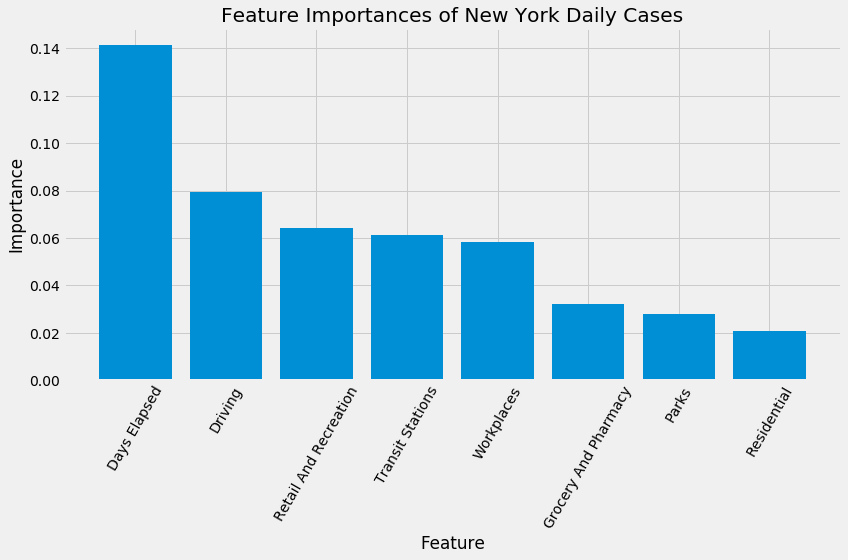

In [302]:
fig, ax = plt.subplots(figsize =(12, 8))
x = feature_importances.index[1:]
y = feature_importances.values[1:].flatten()
ax.bar(x, y)
ax.set_xticklabels(x, rotation = 60)
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
ax.set_title('Feature Importances of New York Daily Cases')
fig.tight_layout()

In [303]:
fig.savefig('images/feature_importances')

In [292]:
feature_importances.values[1:].flatten()

array([0.1414, 0.0795, 0.0642, 0.0611, 0.0583, 0.0322, 0.0278, 0.0209])

NameError: name 'XX' is not defined

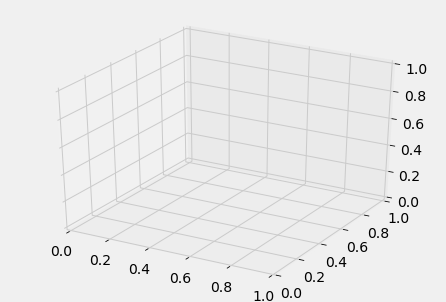

In [58]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                        cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(boston.feature_names[target_feature[0]])
ax.set_ylabel(boston.feature_names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=230)
plt.colorbar(surf)